# Christmas Data Science Competition

Author: Hans-Jörg Stark   
Date: December 2021

For easier access links to main sections in this document:

<a href="#Part0">Part 0: Load the data and data-wrangling</a>    
<a href="#Part1">Part 1: Analysis on the week position</a>    
<a href="#Part2">Part 2: Analysis on the weeks on the chart</a>

## Questions to answer:
___1. What can you tell me about week position?___   
___2. What can you tell me about weeks on the chart?___

_Just in case you need to install additional packages - uncomment the leading hash and rund the code!_

In [1]:
import sys
#!{sys.executable} -m pip install pandasql
#!{sys.executable} -m pip install statsmodels
#!{sys.executable} -m pip install Pingouin #necessary for Welch's ANOVA
#!{sys.executable} -m pip install seaborn_qqplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load some modules first
import os
import pandas as pd
from pandasql import sqldf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<a id="Part0"></a>

## Part 0: Load the data and do some data-wrangling and quality checks


In [4]:
#in MS Excel I added a new column 'performerGroup' that indicates whether the performer of the song was a group (1)
#or and individual (0)

#load the data
path='/Users/hansjoerg.stark/Library/Mobile Documents/com~apple~CloudDocs/Privat/Weiterbildung/Bethel-DataScience/_Projects/xmasChallenge/BethelTechChristmasDataScienceCompetition2021/Data'
rawDataFl = os.path.join(path,'christmas_billboard_data.xlsx')
dfXmasSongsRaw = pd.read_excel(rawDataFl)
dfXmasSongsRaw.head(3)


,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,weeks_on_chart,year,month,day
0,http://www.billboard.com/charts/hot-100/2000-0...,2000-01-01 00:00:00,53,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,NaN,49,3,2000,1,1
1,http://www.billboard.com/charts/hot-100/2000-0...,2000-08-01 00:00:00,49,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,53.0,49,3,2000,1,8
2,http://www.billboard.com/charts/hot-100/2000-0...,1/15/2000,79,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,49.0,49,3,2000,1,15


_Compute the __season__ for each song - some songs with instance > 1 will have more than one season_   
The season is the year in which Christmas was - if songs are in January of the following year still on the chart set the season for this record to "year-1" so it matches with the proper season to which it belongs to.

In [5]:
#create date from year,month,day
dfXmasSongsRaw['date'] = pd.to_datetime(dfXmasSongsRaw[['year', 'month', 'day']])
dfXmasSongsRaw['date']

0     2000-01-01
1     2000-01-08
2     2000-01-15
3     2006-12-09
4     2017-01-07
         ...    
382   2017-01-07
383   2017-01-14
384   1980-12-27
385   1981-01-03
386   1981-01-10
Name: date, Length: 387, dtype: datetime64[ns]

In [6]:
dfXmasSongsRaw['season'] = dfXmasSongsRaw['year']
yearMinusOne4Season = (dfXmasSongsRaw.month==1)
dfXmasSongsRaw.loc[yearMinusOne4Season, 'season']=dfXmasSongsRaw['year']-1
dfXmasSongsRaw[['season','date']][2:5]

,season,date
2,1999,2000-01-15
3,2006,2006-12-09
4,2016,2017-01-07


### Do Some Data Wrangling

In [7]:
#there is a nasty $ in the song column of the 5th dataset - replace $ with S
dfXmasSongsRaw['songid'] = dfXmasSongsRaw['songid'].apply(lambda x: str(x.replace('$','s')))
dfXmasSongsRaw['song'] = dfXmasSongsRaw['song'].apply(lambda x: str(x.replace('$','S')))
dfXmasSongsRaw[4:5]

,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,weeks_on_chart,year,month,day,date,season
4,http://www.billboard.com/charts/hot-100/2017-0...,2017-07-01 00:00:00,48,IT'S THE MOST WONDERFUL TIME OF THE YEAR,Andy Williams,0,It's The Most Wonderful Time Of The YearAndy W...,1,NaN,48,1,2017,1,7,2017-01-07,2016


Get the Progress - backwards or forwards in the charts - and save it as a new variable 'positionChangeWithinWeek'.

In [8]:
dfXmasSongsRaw['positionChangeWithinWeek'] = dfXmasSongsRaw['week_position'] - dfXmasSongsRaw['previous_week_position']
dfXmasSongsWithPositionChange = dfXmasSongsRaw[dfXmasSongsRaw['positionChangeWithinWeek'].notnull()]
dfXmasSongsWithPositionChange.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 1 to 386
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   url                       279 non-null    object        
 1   weekid                    279 non-null    object        
 2   week_position             279 non-null    int64         
 3   song                      279 non-null    object        
 4   performer                 279 non-null    object        
 5   performerGroup            279 non-null    int64         
 6   songid                    279 non-null    object        
 7   instance                  279 non-null    int64         
 8   previous_week_position    279 non-null    float64       
 9   peak_position             279 non-null    int64         
 10  weeks_on_chart            279 non-null    int64         
 11  year                      279 non-null    int64         
 12  month                 

There are 279 records of 387 that have a change in position from a previous week (72.1%).

Compute the number of days between the date of the record and Christmas.   
First: define closest Xmas date: for dates in Nov and Dec it is the same year, for dates in Jan it is the previous year.

In [9]:
dfXmasSongsRaw['xmasDate'] = np.where(dfXmasSongsRaw['month'] >10,dfXmasSongsRaw['year'].map(str)+'-12-25', (dfXmasSongsRaw['year']-1).map(str)+'-12-25')
dfXmasSongsRaw['xmasDate'] = pd.to_datetime(dfXmasSongsRaw['xmasDate'])

In [10]:
dfXmasSongsRaw['numberOfDaysToXmas'] = (dfXmasSongsRaw['xmasDate'] - dfXmasSongsRaw['date']).dt.days
dfXmasSongsRaw[['numberOfDaysToXmas','date']][:6] 

,numberOfDaysToXmas,date
0,-7,2000-01-01
1,-14,2000-01-08
2,-21,2000-01-15
3,16,2006-12-09
4,-13,2017-01-07
5,18,2013-12-07


In [11]:
#get some basic information on the dataset, especially data-types
dfXmasSongsRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   url                       387 non-null    object        
 1   weekid                    387 non-null    object        
 2   week_position             387 non-null    int64         
 3   song                      387 non-null    object        
 4   performer                 387 non-null    object        
 5   performerGroup            387 non-null    int64         
 6   songid                    387 non-null    object        
 7   instance                  387 non-null    int64         
 8   previous_week_position    279 non-null    float64       
 9   peak_position             387 non-null    int64         
 10  weeks_on_chart            387 non-null    int64         
 11  year                      387 non-null    int64         
 12  month                 

In [12]:
#how many unique songs are there? --> 70
print(len(dfXmasSongsRaw['song'].unique()))
uniqueSongs=dfXmasSongsRaw['song'].unique()
uniqueSongs

70


array(['THIS GIFT', 'GREATEST TIME OF YEAR',
       "IT'S THE MOST WONDERFUL TIME OF THE YEAR", 'LAST CHRISTMAS',
       'SANTA TELL ME', "DO THEY KNOW IT'S CHRISTMAS?", 'WHITE CHRISTMAS',
       'SILENT NIGHT', "MONSTERS' HOLIDAY", 'CHRISTMAS AULD LANG SYNE',
       'CHILD OF GOD', 'JINGLE BELL ROCK', 'LET IT SNOW',
       "ROCKIN' AROUND THE CHRISTMAS TREE", 'THIS TIME OF THE YEAR',
       'BELIEVE', 'A HOLLY JOLLY CHRISTMAS',
       'PLEASE COME HOME FOR CHRISTMAS', 'THIS CHRISTMAS',
       'RUN RUDOLPH RUN', 'MISTLETOE', 'CHRISTMAS LIGHTS',
       "BABY'S FIRST CHRISTMAS", 'SAME OLD LANG SYNE',
       'THE HAPPY REINDEER',
       "THE CHIPMUNK SONG (CHRISTMAS DON'T BE LATE)",
       'GRANDMA GOT RUN OVER BY A REINDEER', 'WINTER WORLD OF LOVE',
       'WHERE ARE YOU CHRISTMAS?', 'WELCOME CHRISTMAS',
       "BABY, IT'S COLD OUTSIDE", 'BETTER DAYS',
       'I BELIEVE IN FATHER CHRISTMAS', 'MY FAVORITE THINGS',
       "SANTA'S A FAT BITCH", "IT DOESN'T HAVE TO BE THAT WAY",
       'CHR

In [13]:
#how many unique artists are there? --> 69
print(len(dfXmasSongsRaw['performer'].unique()))
uniquePerformer=dfXmasSongsRaw['performer'].unique()
uniquePerformer

69


array(['98 Degrees', 'Aly & AJ', 'Andy Williams', 'Ariana Grande',
       'Band-Aid', 'Bing Crosby',
       'Bobby "Boris" Pickett And The Crypt-Kickers', 'Bobby Darin',
       'Bobby Helms', 'Bobby Rydell/Chubby Checker', 'Boyz II Men',
       'Brenda Lee', 'Brook Benton', 'Brooks & Dunn', 'Burl Ives',
       'Charles Brown', 'Chris Brown', 'Chuck Berry', 'Colbie Caillat',
       'Coldplay', 'Connie Francis', 'Dan Fogelberg',
       'Dancer, Prancer And Nervous', 'David Seville And The Chipmunks',
       'Eagles', 'Elmo & Patsy', 'Engelbert Humperdinck', 'Faith Hill',
       'Glee Cast', 'Goo Goo Dolls', 'Greg Lake',
       'Herb Alpert & The Tijuana Brass', 'Insane Clown Posse',
       'Jim Croce', 'John Denver', 'Jose Feliciano', 'Justin Bieber',
       'Kelly Clarkson', 'Kenny G', 'Kenny Rogers', 'Los Del Rio',
       'Mariah Carey', 'Merle Haggard', 'Michael Buble', 'Michael Holm',
       'Nat King Cole', 'New Kids On The Block', 'NewSong', 'Perry Como',
       'Ray Stevens', 'Roy

In [14]:
#how many unique combinations of songs and artists are there? --> 78
print(len(dfXmasSongsRaw['songid'].unique()))


78


In [15]:
sqlUniqueSongs = sqldf("select distinct performer, song from dfXmasSongsRaw order by performer;")
sqlUniqueSongs


,performer,song
0,98 Degrees,THIS GIFT
1,Aly & AJ,GREATEST TIME OF YEAR
2,Andy Williams,IT'S THE MOST WONDERFUL TIME OF THE YEAR
3,Ariana Grande,LAST CHRISTMAS
4,Ariana Grande,SANTA TELL ME
...,...,...
73,The Tractors,THE SANTA CLAUS BOOGIE
74,Train,SHAKE UP CHRISTMAS
75,Vic Dana,LITTLE ALTAR BOY
76,Wham!,LAST CHRISTMAS


In [16]:
#check if there are entries without a perfomer
dfXmasSongsRaw[dfXmasSongsRaw['song'].isna()]

,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,weeks_on_chart,year,month,day,date,season,positionChangeWithinWeek,xmasDate,numberOfDaysToXmas


In [17]:
#quality check
sqlCheck = sqldf("""select songid,song,performer, 
                    peak_position as PeakPosition,
                    min(week_position) as MinWeekPosition,
                    peak_position - min(week_position) as delta
                    from dfXmasSongsRaw 
                    group by songid
                    having peak_position - min(week_position) != 0
                    order by delta desc;""")
sqlCheck

,songid,song,performer,PeakPosition,MinWeekPosition,delta
0,Same Old Lang SyneDan Fogelberg,SAME OLD LANG SYNE,Dan Fogelberg,9,14,-5
1,Better DaysGoo Goo Dolls,BETTER DAYS,Goo Goo Dolls,36,48,-12
2,BelieveBrooks & Dunn,BELIEVE,Brooks & Dunn,60,86,-26


__--> data anomalies: for these 3 songs the min(week-Position) and the peak-position are not consistent!!__

<a id="Part1"></a>
## Part 1: Investigation on Week Position

### What were the songs with the most successful advance in the charts?

Assumption: success = largest interval from worst to best week-position per season


In [18]:
sqlBest1 = sqldf("""select song,performer,season,year||"-"||month||"-"||day as timestamp, 
                    min(week_position) as MinWeekPosition,
                    max(week_position) as MaxWeekPosition,
                    max(week_position)-min(week_position) as weekPositionRange,  
                    avg(week_position) as AverageWeekPosition
                    from dfXmasSongsRaw 
               group by songid,season order by weekPositionRange desc limit 10;""")
sqlBest1


,song,performer,season,timestamp,MinWeekPosition,MaxWeekPosition,weekPositionRange,AverageWeekPosition
0,AMEN,The Impressions,1964,1964-11-21,7,96,89,31.818182
1,MISTLETOE,Justin Bieber,2011,2011-12-3,11,96,85,50.900000
2,AULD LANG SYNE,Kenny G,1999,1999-12-25,7,89,82,44.800000
3,THIS ONE'S FOR THE CHILDREN,New Kids On The Block,1989,1989-11-11,7,82,75,26.250000
4,IF WE MAKE IT THROUGH DECEMBER,Merle Haggard,1973,1973-11-24,28,97,69,59.600000
5,WINTER WORLD OF LOVE,Engelbert Humperdinck,1969,1969-12-6,16,84,68,40.666667
6,SAME OLD LANG SYNE,Dan Fogelberg,1980,1980-12-13,14,75,61,37.250000
7,PLEASE COME HOME FOR CHRISTMAS,Eagles,1978,1978-12-9,18,78,60,34.500000
8,THE HAPPY REINDEER,"Dancer, Prancer And Nervous",1959,1960-1-9,34,93,59,68.500000
9,CHRISTMAS LIGHTS,Coldplay,2010,2011-1-1,25,83,58,47.666667


Assumption: success = best week-position ever during their presence in the charts - regardless of season.


In [19]:
sqlBest2 = sqldf("""select song,performer,year||"-"||month||"-"||day as timestamp, 
                    peak_position as PeakPosition,
                    weeks_on_chart as WeeksOnChart,
                    min(week_position) as MinWeekPosition,
                    max(week_position) as MaxWeekPosition,
                    max(week_position)-min(week_position) as weekPositionRange,  
                    avg(week_position) as AverageWeekPosition
                    from dfXmasSongsRaw 
               group by songid order by peak_position asc limit 10;""")
sqlBest2

,song,performer,timestamp,PeakPosition,WeeksOnChart,MinWeekPosition,MaxWeekPosition,weekPositionRange,AverageWeekPosition
0,AMEN,The Impressions,1964-11-21,7,11,7,96,89,31.818182
1,AULD LANG SYNE,Kenny G,1999-12-25,7,5,7,89,82,44.800000
2,THIS ONE'S FOR THE CHILDREN,New Kids On The Block,1989-11-11,7,16,7,82,75,26.250000
3,SAME OLD LANG SYNE,Dan Fogelberg,1980-12-13,9,18,14,75,61,37.250000
4,ALL I WANT FOR CHRISTMAS IS YOU,Mariah Carey,2000-1-8,11,19,11,83,72,28.947368
5,MISTLETOE,Justin Bieber,2011-12-3,11,10,11,96,85,50.900000
6,WHITE CHRISTMAS,Bing Crosby,1958-12-20,12,13,12,86,74,44.357143
7,DO THEY KNOW IT'S CHRISTMAS?,Band-Aid,1984-12-22,13,9,13,65,52,32.500000
8,ROCKIN' AROUND THE CHRISTMAS TREE,Brenda Lee,1962-12-15,14,18,14,89,75,49.210526
9,PRETTY PAPER,Roy Orbison,1963-12-14,15,7,15,60,45,30.285714


### Analysis on whether the average week-position is better before or after Christmas   


#### Analysis on the songs position before or after Christmas

In [20]:
#Get the months songs are in the charts
sqlMonthsOfPresenceInCharts = sqldf("select DISTINCT month from dfXmasSongsRaw order by month;")
sqlMonthsOfPresenceInCharts

,month
0,1
1,11
2,12


In [21]:
#Check if a song has better position before Christmas
sqlBetterBeforeChristmas = sqldf("select count(*) as CountOfBetterBeforeXmas from dfXmasSongsRaw where positionChangeWithinWeek<0 and (month==11 OR (month==12 AND day<=24) );")
sqlBetterBeforeChristmas

,CountOfBetterBeforeXmas
0,81


In [22]:
#Check if a song has better position after Christmas
sqlBetterAfterChristmas = sqldf("select count(*) as CountOfBetterAfterXmas from dfXmasSongsRaw where positionChangeWithinWeek<0 and (month==1 OR (month==12 AND day>24) );")
sqlBetterAfterChristmas


,CountOfBetterAfterXmas
0,119


In [23]:
#get all songs with their initial rank
dfXmasSongsRaw['initialStartPosition'] = dfXmasSongsRaw['previous_week_position'].isnull()*dfXmasSongsRaw['week_position']
dfXmasSongsRaw['initialStartPosition'][:5] 

0    53
1     0
2     0
3    96
4    48
Name: initialStartPosition, dtype: int64

In [24]:
sqlPerformerSongRanking = sqldf("""select distinct performer, song, min(initialStartPosition) 
               as initialPosition from dfXmasSongsRaw where initialStartPosition > 0 
               group by songid order by performer;""")
sqlPerformerSongRanking

,performer,song,initialPosition
0,98 Degrees,THIS GIFT,53
1,Aly & AJ,GREATEST TIME OF YEAR,96
2,Andy Williams,IT'S THE MOST WONDERFUL TIME OF THE YEAR,48
3,Ariana Grande,LAST CHRISTMAS,96
4,Ariana Grande,SANTA TELL ME,65
...,...,...,...
72,The Tractors,THE SANTA CLAUS BOOGIE,91
73,Train,SHAKE UP CHRISTMAS,99
74,Vic Dana,LITTLE ALTAR BOY,99
75,Wham!,LAST CHRISTMAS,50


In [25]:
meanInitialPosition = sqldf("select avg(initialPosition) as averageInitialPosition from (select distinct performer, song, min(initialStartPosition) as initialPosition from dfXmasSongsRaw where initialStartPosition > 0 group by songid order by performer);")
meanInitialPosition['averageInitialPosition']               
               
               

0    75.25974
Name: averageInitialPosition, dtype: float64

In [26]:
meanOverallPosition = sqldf("select avg(week_position) as averageOverallPosition from dfXmasSongsRaw  ;")
meanOverallPosition['averageOverallPosition']               


0    57.204134
Name: averageOverallPosition, dtype: float64

__This means that on average the inital position of a song is worse or higher than the overall average position of all songs during their presence in the charts.__

Checking the median instead of average

In [27]:
dfInitialPostBySongId = sqldf("select Distinct songid,initialPosition from (select distinct songid, min(initialStartPosition) as initialPosition from dfXmasSongsRaw where initialStartPosition > 0 group by songid order by performer);")
dfInitialPostBySongId['initialPosition'].median()

82.0

In [28]:
dfPostBySongId = sqldf("select week_position from dfXmasSongsRaw where week_position > 0;")
dfPostBySongId['week_position'].median()

58.0

In [29]:
dfXmasSongsRaw['week_position'].describe()

count    387.000000
mean      57.204134
std       25.398527
min        7.000000
25%       38.500000
50%       58.000000
75%       78.000000
max      100.000000
Name: week_position, dtype: float64

Text(0, 0.5, 'Frequency')

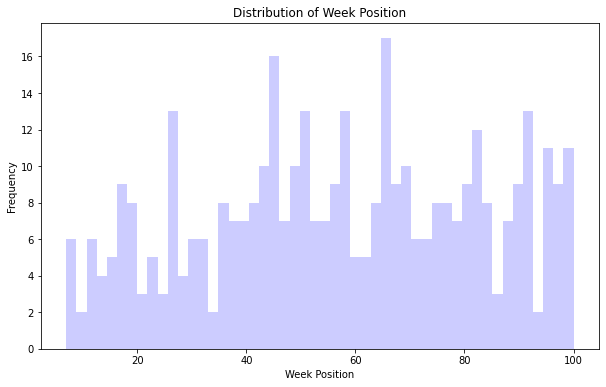

In [30]:
ax = dfXmasSongsRaw['week_position'].plot(kind='hist', bins=50, alpha=0.2, color = 'Blue', figsize=(10,6), title='Distribution of Week Position')
ax.set_xlabel("Week Position")
ax.set_ylabel("Frequency")

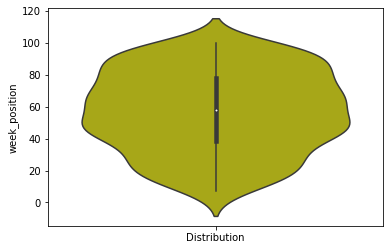

In [31]:
#Distribution and their shape of the values of week-position of the songs
ax = sns.violinplot(y=dfXmasSongsRaw['week_position'], color='y', )
ax = ax.set_xticklabels(['Distribution'])


### Influence of week-position before or after Christmas

Null Hypthesis H0 = ___The average week-position is independent of whether the week-position is before or after Christmas. i.e. the two group means of the groups – before and after Christmas – are the same.___

Run a t-test

In [32]:
#Datawrangling: variable that indicateds week-position before (1) or after(0) Christmas:
dfXmasSongsRaw['BeforeXmas'] = np.where(dfXmasSongsRaw.numberOfDaysToXmas>=0,1,0)
dfXmasSongsRaw[['BeforeXmas','date']][:6]

,BeforeXmas,date
0,0,2000-01-01
1,0,2000-01-08
2,0,2000-01-15
3,1,2006-12-09
4,0,2017-01-07
5,1,2013-12-07


In [33]:
#Split the dataset
dfBeforeXmas = dfXmasSongsRaw.loc[dfXmasSongsRaw['BeforeXmas'] == 1, 'week_position'].to_numpy()
dfAfterXmas = dfXmasSongsRaw.loc[dfXmasSongsRaw['BeforeXmas'] == 0, 'week_position'].to_numpy()
from scipy import stats as st
st.ttest_ind(a=dfBeforeXmas, b=dfAfterXmas, equal_var=True)

Ttest_indResult(statistic=6.039361586928741, pvalue=3.6477473502018717e-09)

The result of the t-test is
```
Ttest_indResult(statistic=6.039361586928741, pvalue=3.6477473502018717e-09)
```
p-value = 3.6477e-09 which is <<0.05 --> the test is significant!   

__H0 is being rejected. The average week-position before Christmas differs significantly from the average week-position after Christmas!__

In [34]:
#get the mean values:
print("Mean Week-Position before Xmas: {}, \nMean Week-Position after Xmas: {}".format(dfBeforeXmas.mean(),dfAfterXmas.mean()))

Mean Week-Position before Xmas: 65.5906432748538, 
Mean Week-Position after Xmas: 50.56481481481482


### Analysis on whether the Song contains "Christmas" in its title
#### Does the song contain "Christmas" in its title?

Null Hypthesis H0 = ___The average position of a song is not dependant on whether the songtitle contains "Christmas".___


In [35]:
#add a column that indicates whether the song contains the word "Christmas"
#dfXmasSongsRaw.loc[dfXmasSongsRaw['stream'] == 2, ['feat','another_feat']] = 'aaaa'
dfXmasSongsRaw['xmasInSong'] = dfXmasSongsRaw['song'].str.contains('CHRISTMAS')
dfXmasSongsRaw[4:7]

,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,...,month,day,date,season,positionChangeWithinWeek,xmasDate,numberOfDaysToXmas,initialStartPosition,BeforeXmas,xmasInSong
4,http://www.billboard.com/charts/hot-100/2017-0...,2017-07-01 00:00:00,48,IT'S THE MOST WONDERFUL TIME OF THE YEAR,Andy Williams,0,It's The Most Wonderful Time Of The YearAndy W...,1,NaN,48,...,1,7,2017-01-07,2016,NaN,2016-12-25,-13,48,0,False
5,http://www.billboard.com/charts/hot-100/2013-1...,2013-07-12 00:00:00,96,LAST CHRISTMAS,Ariana Grande,0,Last ChristmasAriana Grande,1,NaN,96,...,12,7,2013-12-07,2013,NaN,2013-12-25,18,96,1,True
6,http://www.billboard.com/charts/hot-100/2014-1...,12/13/2014,65,SANTA TELL ME,Ariana Grande,0,Santa Tell MeAriana Grande,1,NaN,42,...,12,13,2014-12-13,2014,NaN,2014-12-25,12,65,1,False


In [36]:
#Count the number of songs that have or have not 'Christmas' in their title
dfXmasSongsRaw.xmasInSong.value_counts()

False    234
True     153
Name: xmasInSong, dtype: int64

In [37]:
sqlUniqueSongsWithChristmasInTitle = sqldf("select distinct songid from dfXmasSongsRaw where xmasInSong;")
sqlUniqueSongsWithChristmasInTitle.count()

songid    34
dtype: int64

In [38]:
sqlUniqueSongsWithoutChristmasInTitle = sqldf("select distinct songid from dfXmasSongsRaw where not xmasInSong;")
sqlUniqueSongsWithoutChristmasInTitle.count()

songid    44
dtype: int64

In [39]:
#split dataframe into 2 parts: one that contains songs that contain "Christmas" in their songtitle, 
#the other part that contains songst that do not have "Christmas" in their title
containsXmasInSongname = dfXmasSongsRaw[dfXmasSongsRaw['xmasInSong']]
containsNotXmasInSongname = dfXmasSongsRaw[dfXmasSongsRaw['xmasInSong']==False]
print(containsXmasInSongname.shape)
print(containsNotXmasInSongname.shape)

(153, 22)
(234, 22)


[Text(0.5, 0, 'Week Position'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Songs with "Christmas" in Title')]

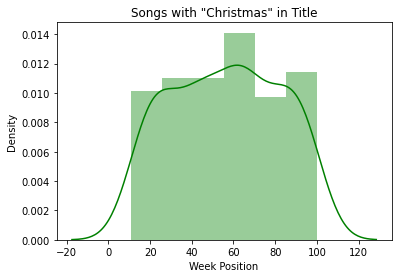

In [40]:
#Histogram of week-position from Songs that contain 'Christmas' in their title
ax = sns.distplot(containsXmasInSongname['week_position'], color = 'green')
ax.set(xlabel='Week Position', ylabel='Density', title='Songs with "Christmas" in Title')


[Text(0.5, 0, 'Week Position'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Songs without "Christmas" in Title')]

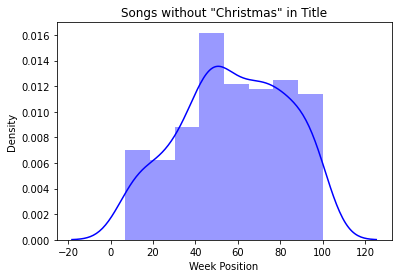

In [41]:
#Histogram of week-position from Songs that do not contain 'Christmas' in their title
ax = sns.distplot(containsNotXmasInSongname['week_position'], color='blue')
ax.set(xlabel='Week Position', ylabel='Density', title='Songs without "Christmas" in Title')


In [42]:
# t-test for independent samples
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t
 
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # calculate standard errors
    se1, se2 = sem(data1), sem(data2)
    # standard error on the difference between the samples
    sed = sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

# calculate the t test
data1 = containsXmasInSongname['week_position']
data2 = containsNotXmasInSongname['week_position']
alpha = 0.05
t_stat, df, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')

t=-0.569, df=385, cv=1.649, p=0.570
Accept null hypothesis H0 that the means are equal.
Accept null hypothesis H0 that the means are equal.


Perform an independent t-test to check whether the average position of a song is significantly different if the song contains or does not contain "Christmas" in the title.   

__H0 = the average position of a song is not dependant on whether the songtitle contains "Christmas" or not.__

_(Source: https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/)_

In [43]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


[Text(0.5, 0, 'all datasets'),
 Text(0, 0.5, 'Weeks on Chart'),
 Text(0.5, 1.0, 'Weeks on Chart split by Title Containing "Christmas"')]

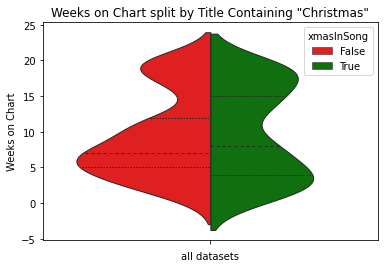

In [44]:
# Draw a nested violinplot and split the violins for easier comparison
dfXmasSongsRaw["all"] = ""
ax = sns.violinplot(data=dfXmasSongsRaw,x="all", y="weeks_on_chart", hue="xmasInSong",
               split=True, inner="quart", linewidth=1, palette={True:"g",False:"r"})
ax.set(xlabel='all datasets', ylabel='Weeks on Chart', title='Weeks on Chart split by Title Containing "Christmas"')


### Does the Performer - individual or group - have a significant influence on week-position?

Null Hypthesis H0 = ___Whether a song is performed by an individual or a group does not have an influence on the week-position in the chart.___


In [45]:
sqlGroupPerformer = sqldf("select distinct songid from dfXmasSongsRaw where performerGroup==1;")
sqlGroupPerformer.count()

songid    33
dtype: int64

In [46]:
sqlIndividualPerformer = sqldf("select distinct songid from dfXmasSongsRaw where performerGroup==0;")
sqlIndividualPerformer.count()

songid    45
dtype: int64

In [47]:
#split dataframe into 2 parts: one that contains songs performed by a group, 
#the other part performed by individuals
groupPerformer = dfXmasSongsRaw[dfXmasSongsRaw['performerGroup']==1]
individualPerformer = dfXmasSongsRaw[dfXmasSongsRaw['performerGroup']==0]
print(groupPerformer.shape)
print(individualPerformer.shape)

(161, 23)
(226, 23)


[Text(0.5, 0, 'Week Position'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Songs performed by groups')]

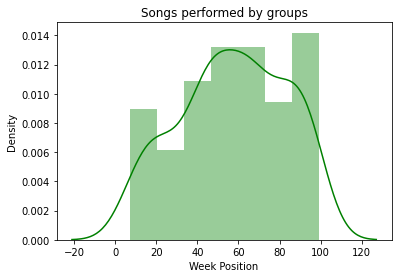

In [48]:
#Histogram of week-position from Songs performed by groups
ax = sns.distplot(groupPerformer['week_position'], color = 'green')
ax.set(xlabel='Week Position', ylabel='Density', title='Songs performed by groups')


[Text(0.5, 0, 'Week Position'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Songs performed by individuals')]

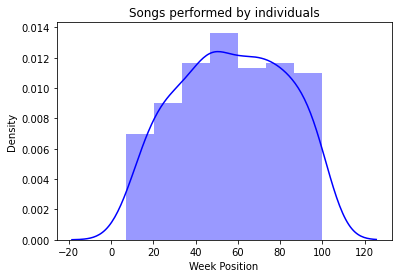

In [49]:
#Histogram of week-position from Songs performed by individuals
ax = sns.distplot(individualPerformer['week_position'], color = 'blue')
ax.set(xlabel='Week Position', ylabel='Density', title='Songs performed by individuals')


In [50]:
# t-test for independent samples
# calculate the t test
data1 = groupPerformer['week_position']
data2 = individualPerformer['week_position']
alpha = 0.05
t_stat, df, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')

t=0.049, df=385, cv=1.649, p=0.961
Accept null hypothesis H0 that the means are equal.
Accept null hypothesis H0 that the means are equal.


p-value = 0.961 --> H0 is accepted: __There is no indication that the performer has a signifcant influence on the week-position of a song in the chart.__

### Influence of Time to Christmas on Week Position
#### Check if the closeness (timewise) to christmas has an influence of week-position

Null Hypthesis H0 = ___The time-distance to Christmas has no significant influence on the week-position of a song in the charts.___


[Text(0.5, 0, 'Number of Days to Christmas'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Number of Days to Christmas')]

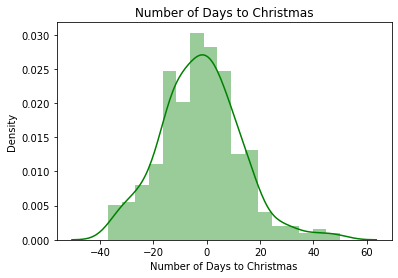

In [51]:
#Histogram of the number of days to Christmas
ax = sns.distplot(dfXmasSongsRaw['numberOfDaysToXmas'], color='green')
ax.set(xlabel='Number of Days to Christmas', ylabel='Density', title='Number of Days to Christmas')


The distribution looks fairly normally distributed!

Create a Scatterplot on number of days to Christmas vs Week-Position:

<AxesSubplot:xlabel='numberOfDaysToXmas', ylabel='week_position'>

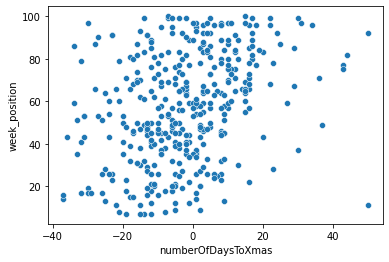

In [52]:
sns.scatterplot(data=dfXmasSongsRaw, x='numberOfDaysToXmas', y='week_position')

Another Scatter-Plot with emphasis on how long the song was on the charts:

<AxesSubplot:xlabel='numberOfDaysToXmas', ylabel='week_position'>

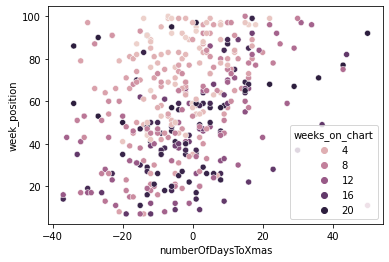

In [53]:
sns.scatterplot(data=dfXmasSongsRaw, x='numberOfDaysToXmas', y='week_position',hue='weeks_on_chart')

Run a simple linear regression on number of days to Christmas (=IV, continuous) versus week-position (=DV, continuous).   

Null Hypothesis H0: __The time-distance to Christmas has no significant influence on the week-position of a song in the charts.__

In [54]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import boxcox

#extract only necessary data into a separate dataframe
dfNoD2XvsWP = dfXmasSongsRaw[['numberOfDaysToXmas','week_position']]
dfNoD2XvsWP

,numberOfDaysToXmas,week_position
0,-7,53
1,-14,49
2,-21,79
3,16,96
4,-13,48
...,...,...
382,-13,50
383,-20,41
384,-2,82
385,-9,82


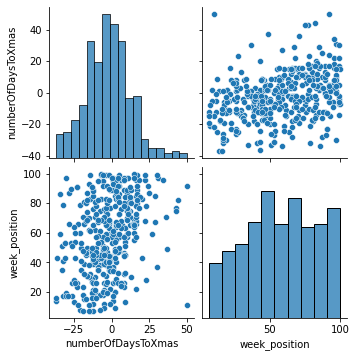

In [55]:
sns.pairplot(dfNoD2XvsWP)

<AxesSubplot:xlabel='numberOfDaysToXmas', ylabel='Density'>

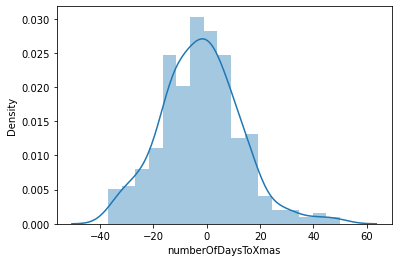

In [56]:
sns.distplot(dfNoD2XvsWP['numberOfDaysToXmas'])

<AxesSubplot:xlabel='week_position', ylabel='Density'>

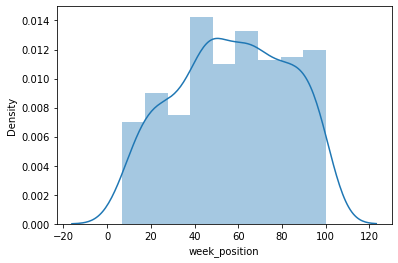

In [57]:
sns.distplot(dfNoD2XvsWP['week_position'])

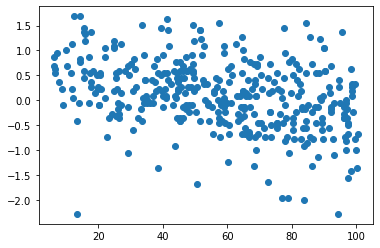

In [58]:
#Testing for Homoscedasticity
x = dfNoD2XvsWP['numberOfDaysToXmas']
y = dfNoD2XvsWP['week_position']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfNoD2XvsWP['week_position'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)

In [59]:
sms.diagnostic.het_breuschpagan(residual, dfNoD2XvsWP[['numberOfDaysToXmas']])
# lagrange multiplier statistic: 2.485
# p-value for the lagrange multiplier statistic: nan
# F value to test for homoscedasticity: 2.494 - looks good
# p-value for test for homoscedasticity: 0.115 --> not significant, no violation of homoscedasticity!

(2.4848718028584504, nan, 2.4944675659460818, 0.11506609039502463)

In [60]:
# Testing for Multicollinearity:
dfNoD2XvsWP.corr()

,numberOfDaysToXmas,week_position
numberOfDaysToXmas,1.000000,0.329601
week_position,0.329601,1.000000


<AxesSubplot:>

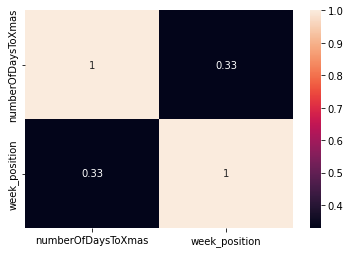

In [61]:
sns.heatmap(dfNoD2XvsWP.corr(), annot=True)

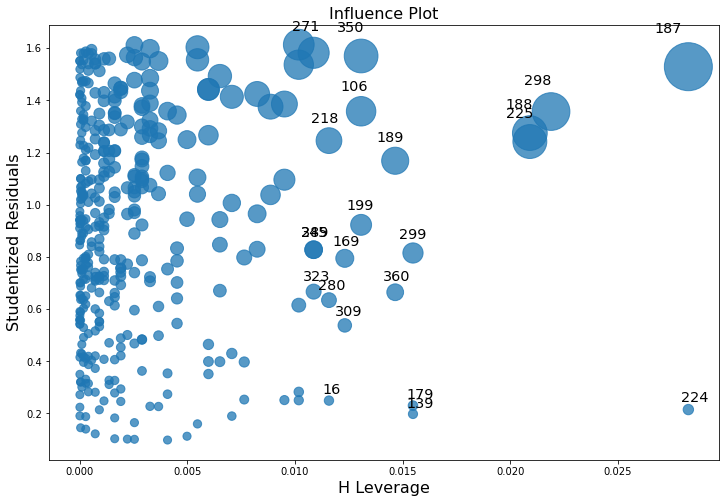

In [62]:
#Screening for Outliers
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

In [63]:
# --> there are outliers!!
# exclude them! :
exclList=[370,212,241,2,76,358,101,191,227,363,301,137,177,345,270,374,272,337,217,288,381,344,289,322,279,15,308,226,105,77,190,351,242,198,300,359,178,16,179,373,271,350,187,213,106,218,189,188,199,299,280,360,309,303,323,153,329,285,27,150,239,223,167,55,171,126,181,192,160,139,138,182,234,295,54,328,265,254,284,143,277,96,296,238,207,246,151,224,168,170,142,297,183,283,282,327,236,281,298,208,237,141,184,152,247,235,169,225,326]
exclListSorted = sorted(exclList)
print(exclListSorted)
print(len(exclListSorted))

[2, 15, 16, 27, 54, 55, 76, 77, 96, 101, 105, 106, 126, 137, 138, 139, 141, 142, 143, 150, 151, 152, 153, 160, 167, 168, 169, 170, 171, 177, 178, 179, 181, 182, 183, 184, 187, 188, 189, 190, 191, 192, 198, 199, 207, 208, 212, 213, 217, 218, 223, 224, 225, 226, 227, 234, 235, 236, 237, 238, 239, 241, 242, 246, 247, 254, 265, 270, 271, 272, 277, 279, 280, 281, 282, 283, 284, 285, 288, 289, 295, 296, 297, 298, 299, 300, 301, 303, 308, 309, 322, 323, 326, 327, 328, 329, 337, 344, 345, 350, 351, 358, 359, 360, 363, 370, 373, 374, 381]
109


In [64]:
dfNoD2XvsWPCleanedFromOutliers = dfNoD2XvsWP.drop(exclList)
dfNoD2XvsWPCleanedFromOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 0 to 386
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   numberOfDaysToXmas  278 non-null    int64
 1   week_position       278 non-null    int64
dtypes: int64(2)
memory usage: 6.5 KB


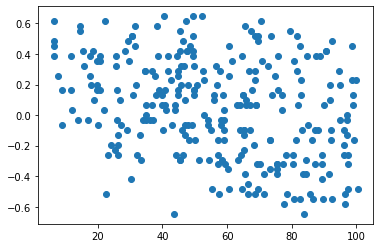

In [65]:
#re-create model:
#Testing for Homoscedasticity
x = dfNoD2XvsWPCleanedFromOutliers['numberOfDaysToXmas']
y = dfNoD2XvsWPCleanedFromOutliers['week_position']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfNoD2XvsWPCleanedFromOutliers['week_position'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)

In [66]:
sms.diagnostic.het_breuschpagan(residual, dfNoD2XvsWPCleanedFromOutliers[['numberOfDaysToXmas']])
# --> p-Value = 0.07, still > 0.05, Homoscedasticity met

(1.3314109936150724, nan, 1.333005841233617, 0.2492662479941024)

In [67]:
# Testing for Multicollinearity:
dfNoD2XvsWPCleanedFromOutliers.corr()

,numberOfDaysToXmas,week_position
numberOfDaysToXmas,1.000000,0.312153
week_position,0.312153,1.000000


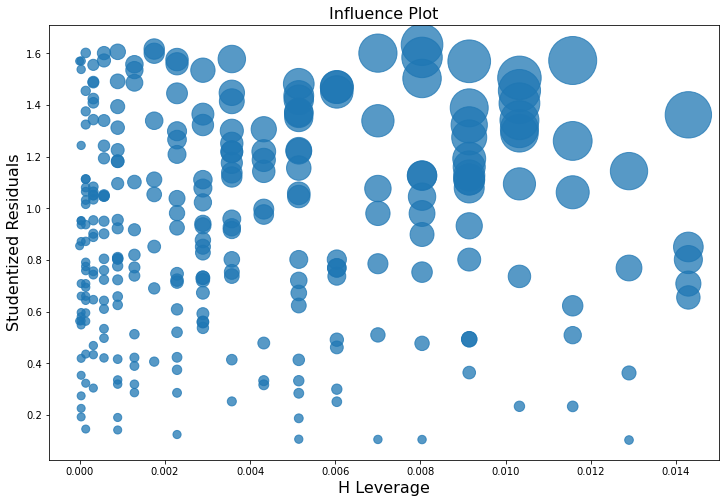

In [68]:
#Screening for Outliers
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

In [69]:
infl = model.get_influence()
infl.summary_frame()[:5]

,dfb_numberOfDaysToXmas,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.035683,0.001275,0.852473,0.001751,0.035701,0.852051,0.035683
1,-0.065985,0.004360,0.786270,0.007003,0.066031,0.785727,0.065985
3,0.150754,0.022607,1.564907,0.009147,0.150358,1.569031,0.150754
4,-0.059990,0.003604,0.770224,0.006039,0.060034,0.769657,0.059990
5,0.170132,0.028792,1.567881,0.011577,0.169682,1.572039,0.170132


In [70]:
infl.summary_frame()['dfb_numberOfDaysToXmas'].sort_values(ascending=False)[:5]
# --> no problem here


5      0.170132
140    0.163987
158    0.153720
3      0.150754
111    0.148698
Name: dfb_numberOfDaysToXmas, dtype: float64

In [71]:
infl.summary_frame()['dffits'].sort_values(ascending=False)[:5]
# --> no problem here

5      0.170132
140    0.163987
158    0.153720
3      0.150754
111    0.148698
Name: dffits, dtype: float64

In [72]:
infl.summary_frame()['hat_diag'].sort_values(ascending=False)[:5]
# --> no problem here

140    0.014292
197    0.014292
233    0.014292
352    0.014292
383    0.014292
Name: hat_diag, dtype: float64

In [73]:
infl.summary_frame()['student_resid'].sort_values(ascending=False)[:5]
# --> no problem here

290    1.633221
252    1.616370
200    1.605674
201    1.601364
122    1.600653
Name: student_resid, dtype: float64

In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          week_position   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                           0.007640
Date:                Sat, 01 Jan 2022   Prob (F-statistic):                       0.930
Time:                        17:48:59   Log-Likelihood:                         -1541.1
No. Observations:                 278   AIC:                                      3084.
Df Residuals:                     277   BIC:                                      3088.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
numberOfDaysToXmas    -0.0324      0.370     -0.087      0.930      -0.761       0.697
==============================================================================
Omnibus:                       37.637   Durbin-Watson:                   0.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.448
Skew:                          -0.086   Prob(JB):                      0.00539
Kurtosis:                       2.066   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation: __Accept H0 that time-distance to Christmas has no significant influence on the week-position of the song!__

UNTERBRUCH 20211230

### Influence of Decade on Week Position
#### Test if the week-position differs significantly during the decades.

Null Hypthesis H0 = ___The decades a song was on the chart has no significant influence on the quality of the week-position of a song.___    

First a re-coding of week-position into four categories is planned. But this turned out to bee to filigrane - it lead to a violation of the prerequisite of at least 5 members per cell. So the recoding was more constrained into two categories as 'good' and 'bad' positions, being divided according to the song's position compared to the median.

Run an Independent Chi-Square Test



In [75]:
dfXmasSongsRaw['decade'] = ((dfXmasSongsRaw['year'])/10 ).astype(int)*10
dfXmasSongsRaw['decade'][:5]


0    2000
1    2000
2    2000
3    2000
4    2010
Name: decade, dtype: int64

In [76]:
dfXmasSongsRaw[['decade','date']][10:18]


,decade,date
10,2010,2015-01-10
11,1980,1984-12-22
12,1980,1984-12-29
13,1980,1985-01-05
14,1980,1985-01-12
15,1980,1985-01-19
16,1980,1985-01-26
17,1950,1958-12-20


In [77]:
#reclassify the week position to a more categorical value based on simple statistics / Quartiles:
# 25%: 38:  0 < x <= 38 --> Class 1 
# 50%: 58: 38 < x <= 58 --> Class 2 
# 75%: 78: 58 < x <= 78 --> Class 3  
#               x >  78 --> Class 4

dfXmasSongsRaw['weekPosCat'] = 4
dfXmasSongsRaw['weekPosCat'] = np.where(dfXmasSongsRaw['week_position']<=78,3,dfXmasSongsRaw['weekPosCat'])
dfXmasSongsRaw['weekPosCat'] = np.where(dfXmasSongsRaw['week_position']<=58,2,dfXmasSongsRaw['weekPosCat'])
dfXmasSongsRaw['weekPosCat'] = np.where(dfXmasSongsRaw['week_position']<=38,1,dfXmasSongsRaw['weekPosCat'])
dfXmasSongsRaw['weekPosCat'].value_counts()

2    98
1    97
4    96
3    96
Name: weekPosCat, dtype: int64

[Text(0.5, 0, 'Peak Position of Song'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Peak Positions of Songs')]

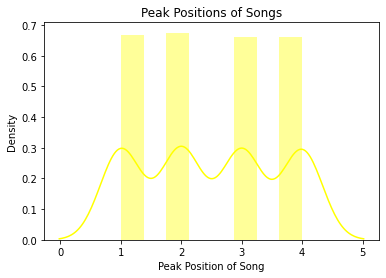

In [78]:
#Histogram of the peak position
ax = sns.distplot(dfXmasSongsRaw['weekPosCat'], color='yellow')
ax.set(xlabel='Peak Position of Song', ylabel='Density', title='Peak Positions of Songs')


Do a ___Chi square test of independence___.    
Assumption: both the DV and IV are categorical, because they are ordinal (decade and re-categorisation of rank).   
Null Hypothesis H0: __there is no significant dependence between means of ‘Decade’ and ‘Week Position’__.

Create a Contingency Table:

In [79]:
xmasWPCByDecCrosstab = pd.crosstab(dfXmasSongsRaw['decade'] , dfXmasSongsRaw['weekPosCat'] , margins=True)
xmasWPCByDecCrosstab

weekPosCat,1,2,3,4,All
decade,,,,,
1950,2,5,8,6,21
1960,31,52,37,24,144
1970,12,7,13,12,44
1980,16,1,7,11,35
1990,5,3,7,9,24
2000,2,11,18,19,50
2010,29,19,6,15,69
All,97,98,96,96,387


__Problem:__ We have cells with fewer than 5 members!    

Run the test anyway in a first approach...

In [80]:
from scipy import stats
stats.chi2_contingency(xmasWPCByDecCrosstab)


(65.0065554156709,
 8.993000292227184e-05,
 28,
 array([[  5.26356589,   5.31782946,   5.20930233,   5.20930233,
          21.        ],
        [ 36.09302326,  36.46511628,  35.72093023,  35.72093023,
         144.        ],
        [ 11.02842377,  11.14211886,  10.91472868,  10.91472868,
          44.        ],
        [  8.77260982,   8.8630491 ,   8.68217054,   8.68217054,
          35.        ],
        [  6.01550388,   6.07751938,   5.95348837,   5.95348837,
          24.        ],
        [ 12.53229974,  12.66149871,  12.40310078,  12.40310078,
          50.        ],
        [ 17.29457364,  17.47286822,  17.11627907,  17.11627907,
          69.        ],
        [ 97.        ,  98.        ,  96.        ,  96.        ,
         387.        ]]))

--> __p-value = 8.993e-05__ --> strong indication for significance!   
___Reject H0!!___

Re-categorise / Recode the values with just two classes: 0 for rankings lower/better than 58 and 1 for rankings above / worse than 58.

In [81]:
#reclassify the week position to a more categorical value based on simple statistics / Quartiles:
# 50%: 58: x <= 58 --> Class 0 
# 50%: 58: x > 58 --> Class 1 

dfXmasSongsRaw['weekPosCat50'] = 1
dfXmasSongsRaw['weekPosCat50'] = np.where(dfXmasSongsRaw['week_position']<=58,0,dfXmasSongsRaw['weekPosCat50'])
dfXmasSongsRaw['weekPosCat50'].value_counts()

0    195
1    192
Name: weekPosCat50, dtype: int64

In [82]:
xmasWPCByDec50Crosstab = pd.crosstab(dfXmasSongsRaw['decade'] , dfXmasSongsRaw['weekPosCat50'] , margins=True)
xmasWPCByDec50Crosstab

weekPosCat50,0,1,All
decade,,,
1950,7,14,21
1960,83,61,144
1970,19,25,44
1980,17,18,35
1990,8,16,24
2000,13,37,50
2010,48,21,69
All,195,192,387


Now all cells have at least 5 members! Condition fulfilled!

In [83]:
from scipy import stats
stats.chi2_contingency(xmasWPCByDec50Crosstab)


(31.271705131485355,
 0.005077737416163921,
 14,
 array([[ 10.58139535,  10.41860465,  21.        ],
        [ 72.55813953,  71.44186047, 144.        ],
        [ 22.17054264,  21.82945736,  44.        ],
        [ 17.63565891,  17.36434109,  35.        ],
        [ 12.09302326,  11.90697674,  24.        ],
        [ 25.19379845,  24.80620155,  50.        ],
        [ 34.76744186,  34.23255814,  69.        ],
        [195.        , 192.        , 387.        ]]))

--> __p-value = 0.00507__ --> There is indication of significance!   
___Reject H0!!___

#### A second test on the  median week position of a song per decade


Null Hypthesis H0 = ___The decade a song was on the chart has no significant influence on the median week-position of a song.___

Run an Independent Chi-Square Test

Prepare the data for analysis on decades vs week-position

In [84]:
dfXmasDecadeWeekPosDec = dfXmasSongsRaw.groupby(dfXmasSongsRaw['decade'])[['decade']].mean()
dfXmasDecadeWeekPosDec['rownr'] = np.arange(dfXmasDecadeWeekPosDec.shape[0])
dfXmasDecadeWeekPosDec


,decade,rownr
decade,,
1950,1950.0,0
1960,1960.0,1
1970,1970.0,2
1980,1980.0,3
1990,1990.0,4
2000,2000.0,5
2010,2010.0,6


In [85]:
#create a pandas' series
serDec = dfXmasDecadeWeekPosDec.iloc[:,0]
serDec


decade
1950    1950.0
1960    1960.0
1970    1970.0
1980    1980.0
1990    1990.0
2000    2000.0
2010    2010.0
Name: decade, dtype: float64

In [86]:
dfXmasDecadeWeekPosAvg = dfXmasSongsRaw.groupby(dfXmasSongsRaw['decade'])[['week_position']].mean()
dfXmasDecadeWeekPosAvg['rownr'] = np.arange(dfXmasDecadeWeekPosAvg.shape[0])
dfXmasDecadeWeekPosAvg.rename(columns={'week_position': 'WeekPositionAvg'},inplace=True)
dfXmasDecadeWeekPosAvg

,WeekPositionAvg,rownr
decade,,
1950,65.904762,0
1960,54.736111,1
1970,59.522727,2
1980,51.028571,3
1990,63.250000,4
2000,69.940000,5
2010,50.028986,6


In [87]:
#create a pandas' series
serAvgWP = dfXmasDecadeWeekPosAvg.iloc[:,0]
serAvgWP


decade
1950    65.904762
1960    54.736111
1970    59.522727
1980    51.028571
1990    63.250000
2000    69.940000
2010    50.028986
Name: WeekPositionAvg, dtype: float64

In [88]:
dfXmasDecadeWeekPosMedian = dfXmasSongsRaw.groupby(dfXmasSongsRaw['decade'])[['week_position']].median()
dfXmasDecadeWeekPosMedian['rownr'] = np.arange(dfXmasDecadeWeekPosMedian.shape[0])
dfXmasDecadeWeekPosMedian.rename(columns={'week_position': 'WeekPositionMedian'},inplace=True)
dfXmasDecadeWeekPosMedian

,WeekPositionMedian,rownr
decade,,
1950,69.0,0
1960,54.0,1
1970,64.5,2
1980,59.0,3
1990,66.5,4
2000,70.0,5
2010,44.0,6


In [89]:
#create a pandas' series
serMedianWP = dfXmasDecadeWeekPosMedian.iloc[:,0]
serMedianWP


decade
1950    69.0
1960    54.0
1970    64.5
1980    59.0
1990    66.5
2000    70.0
2010    44.0
Name: WeekPositionMedian, dtype: float64

In [90]:
#merge the series
dfAvgMedWPByDecade = pd.concat([serAvgWP,serMedianWP,serDec],axis=1)
dfAvgMedWPByDecade


,WeekPositionAvg,WeekPositionMedian,decade
decade,,,
1950,65.904762,69.0,1950.0
1960,54.736111,54.0,1960.0
1970,59.522727,64.5,1970.0
1980,51.028571,59.0,1980.0
1990,63.250000,66.5,1990.0
2000,69.940000,70.0,2000.0
2010,50.028986,44.0,2010.0


Do a ___Chi square test of independence___.    

Assumption: both the DV and IV are categorical, because they are ordinal (decade and rank).

Create a Contingency Table:


In [91]:
xmasMedByDecCrosstab = pd.crosstab(dfAvgMedWPByDecade.decade, dfAvgMedWPByDecade.WeekPositionMedian, margins=True)
xmasMedByDecCrosstab

WeekPositionMedian,44.0,54.0,59.0,64.5,66.5,69.0,70.0,All
decade,,,,,,,,
1950.0,0,0,0,0,0,1,0,1
1960.0,0,1,0,0,0,0,0,1
1970.0,0,0,0,1,0,0,0,1
1980.0,0,0,1,0,0,0,0,1
1990.0,0,0,0,0,1,0,0,1
2000.0,0,0,0,0,0,0,1,1
2010.0,1,0,0,0,0,0,0,1
All,1,1,1,1,1,1,1,7


In [92]:
from scipy import stats
stats.chi2_contingency(xmasMedByDecCrosstab)


(42.000000000000014,
 0.7503696058068774,
 49,
 array([[0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714, 0.14285714, 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 7.        ]]))

__p-value = 0.75__ --> no significant differences of rankings between the decades.   
BUT... problem again: we do not have at least 5 cases per cell...

In [93]:
#Try correlation between Median week position and decade:
dfAvgMedWPByDecade['WeekPositionMedian'].corr(dfAvgMedWPByDecade['decade'])

-0.33672228418685873

Interpretation: there is a weak to medium negative correlation between median week position and decade.    
In other words: in last century the median week positions were in tendence better than in the recent years.

Do a more visual analysis with a scatter plot

<AxesSubplot:xlabel='decade', ylabel='WeekPositionMedian'>

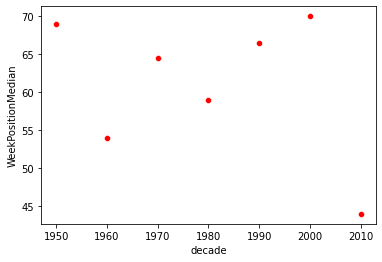

In [94]:
#Scatterplot of date vs weeks on chart
sns.scatterplot(data=dfAvgMedWPByDecade, x='decade', y='WeekPositionMedian',color='red')

<AxesSubplot:xlabel='decade', ylabel='WeekPositionMedian'>

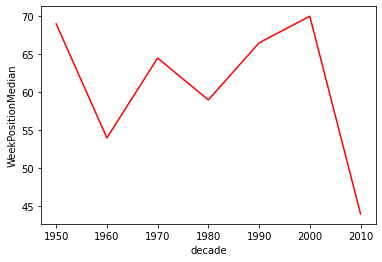

In [95]:
sns.lineplot(data=dfAvgMedWPByDecade, x='decade', y='WeekPositionMedian',color='red')

<AxesSubplot:xlabel='WeekPositionMedian'>

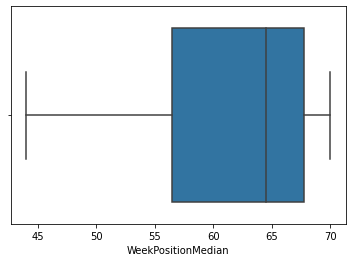

In [96]:
sns.boxplot(data=dfAvgMedWPByDecade, x='WeekPositionMedian')

### Test if the month (Nov, Dec or Jan) is significantly influencing the week-position


Null Hypthesis H0 = ___The month of a song's position has no significant influence on the week-position of a song.___

IV: month as categorical variable (with 3 levels, one for each month)
DV: week-position as continuous variable

Run ANOVA test

In [97]:
import scipy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [98]:
#Only Keep the 2 Varaibles that are necessary
xmasSongsMonthVsWP = dfXmasSongsRaw[['week_position', 'month']]
print(xmasSongsMonthVsWP['week_position'].value_counts())
print(xmasSongsMonthVsWP['month'].value_counts())
print(xmasSongsMonthVsWP.info())

45    10
26    10
59     9
97     9
65     9
      ..
15     2
42     2
79     2
36     1
24     1
Name: week_position, Length: 89, dtype: int64
12    224
1     148
11     15
Name: month, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   week_position  387 non-null    int64
 1   month          387 non-null    int64
dtypes: int64(2)
memory usage: 6.2 KB
None


In [99]:
#Recode month information
def recode (mth): 
    if mth == 11: 
        return "Nov"
    if mth == 12: 
        return "Dec"
    if mth == 1: 
        return "Jan"

xmasSongsMonthVsWP['monthR'] = xmasSongsMonthVsWP['month'].apply(recode)
print(xmasSongsMonthVsWP.info())
print(xmasSongsMonthVsWP['monthR'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   week_position  387 non-null    int64 
 1   month          387 non-null    int64 
 2   monthR         387 non-null    object
dtypes: int64(2), object(1)
memory usage: 9.2+ KB
None
Dec    224
Jan    148
Nov     15
Name: monthR, dtype: int64


<AxesSubplot:xlabel='week_position', ylabel='Density'>

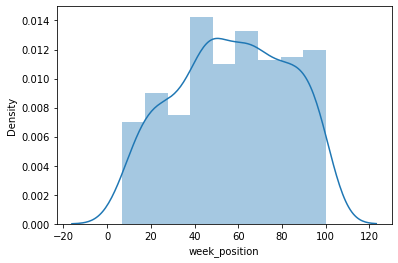

In [100]:
#Test for normality
sns.distplot(xmasSongsMonthVsWP['week_position'])

<AxesSubplot:xlabel='week_positionSQRT', ylabel='Density'>

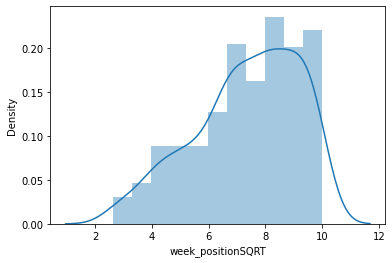

In [101]:
xmasSongsMonthVsWP['week_positionSQRT'] = np.sqrt(xmasSongsMonthVsWP['week_position'])
sns.distplot(xmasSongsMonthVsWP['week_positionSQRT'])

<AxesSubplot:xlabel='week_positionLOG', ylabel='Density'>

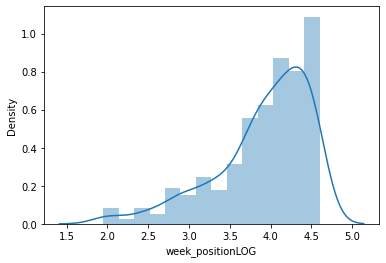

In [102]:
xmasSongsMonthVsWP['week_positionLOG'] = np.log(xmasSongsMonthVsWP['week_position'])
sns.distplot(xmasSongsMonthVsWP['week_positionLOG'])

In [103]:
xmasSongsMonthVsWP.drop(['week_positionSQRT', 'week_positionLOG'], axis=1,inplace=True)

--> the original data looks best - no log or sqrt performed!

In [104]:
#Test for Homogeneity of Variance
scipy.stats.bartlett(xmasSongsMonthVsWP['week_position'], xmasSongsMonthVsWP['month'])

BartlettResult(statistic=703.1903972002012, pvalue=6.0524826721612594e-155)

_Unfortunately does not meet the assumption of homogeneity of variance: p-value = 6.052e-155 Variance is unequal, violation of assumption of homogeneity!_   
Keep going anyway... run the analysis:

In [105]:
stats.f_oneway(xmasSongsMonthVsWP['week_position'][xmasSongsMonthVsWP['monthR']=='Nov'],
                   xmasSongsMonthVsWP['week_position'][xmasSongsMonthVsWP['monthR']=='Dec'],
               xmasSongsMonthVsWP['week_position'][xmasSongsMonthVsWP['monthR']=='Jan'])

F_onewayResult(statistic=14.180633815759432, pvalue=1.1435227378678987e-06)

*__p-value is < 0.05__ --> reject HO*. In other words: __The months significantly influences the week position of a song!__

In [106]:
#PostHoc
postHoc = MultiComparison(xmasSongsMonthVsWP['week_position'], xmasSongsMonthVsWP['month'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1     11  23.1045 0.0017   7.4373 38.7717   True
     1     12  12.3468  0.001    6.222 18.4715   True
    11     12 -10.7577 0.2298 -26.1784  4.6629  False
-----------------------------------------------------


In [107]:
#Examine means first
xmasSongsMonthVsWP.groupby('monthR').mean()

,week_position,month
monthR,,
Dec,61.508929,12.0
Jan,49.162162,1.0
Nov,72.266667,11.0


__Looks like in _November_ the week-positions are best, followed by _December_ and finally _January_.__

In [108]:
# Because of violation of the assumption of homegeineity run Welch's ANOVA
# Source: https://www.statology.org/welchs-anova-in-python/
import pingouin as pg
pg.welch_anova(dv='week_position', between='monthR', data=xmasSongsMonthVsWP)


,Source,ddof1,ddof2,F,p-unc,np2
0,monthR,2,38.344556,13.612837,0.000034,0.068778


__The overall p-value (0.000034) from the ANOVA table is less than α = .05, which means we can reject the null hypothesis that the week positions are equal between the three months.__

In [109]:
#Perform a Games-Howell post-hoc test to determine exactly which group means are different:
pg.pairwise_gameshowell(dv='week_position', between='monthR', data=xmasSongsMonthVsWP)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Dec,Jan,61.508929,49.162162,12.346766,2.627381,4.699267,304.571722,0.001000,0.496781
1,Dec,Nov,61.508929,72.266667,-10.757738,6.572620,-1.636750,15.842499,0.259827,-0.435145
2,Jan,Nov,49.162162,72.266667,-23.104505,6.701693,-3.447562,17.110140,0.008113,-0.929819


The p-values in the table above show:
* __the mean difference between December and January are significantly different__
* __the mean difference between November and January are significantly different__


### Finally some general information on week’s position of songs:


In [110]:
sqlOut = sqldf("""select min(week_position) as MinWeekPosition,max(week_position) as MaxWeekPosition,avg(week_position) as MinWeekPosition,max(week_position)-min(week_position) as weekPosRange, songid from dfXmasSongsRaw 
               group by songid order by weekPosRange desc;""")
sqlOut


,MinWeekPosition,MaxWeekPosition,MinWeekPosition,weekPosRange,songid
0,7,96,31.818182,89,AmenThe Impressions
1,11,96,50.900000,85,MistletoeJustin Bieber
2,7,89,44.800000,82,Auld Lang SyneKenny G
3,21,97,49.625000,76,Jingle Bell RockBobby Rydell/Chubby Checker
4,7,82,26.250000,75,This One's For The ChildrenNew Kids On The Block
...,...,...,...,...,...
73,92,92,92.000000,0,Do They Know It's Christmas?Glee Cast
74,95,95,95.000000,0,Child Of GodBobby Darin
75,97,97,97.000000,0,Blue ChristmasThe Browns Featuring Jim Edward ...
76,99,99,99.000000,0,All I Want For Christmas Is YouMichael Buble


<a id="Part2"></a>
## Part 2: Investigation Weeks on Chart

Work on the following aspects regarding Weeks on Chart (WoC):
* basic statistics on WoC
* influence of performer type
* influence of decade
* influence of peak-position
* influence of (month of) first appearance
* influence of time-to-christmas of first appearance
* influence of "Christmas" in Title
* influence of instance
* run a ML model to predict weeks on chart and get the influence factors

<font color="red">_There is a problem that some data is only available on song-ID level. For instance, the peak-position is the same for one song no matter whether it was more than once or just once on the charts (instance =1 or instance > 1). The same is true of the number of weeks on the charts: it is an overall sum not the number of weeks on chart for one season. This makes it difficult to compare the data is some ways.<p> This artefact needs to be kept in mind for the following investigations and is illustrated in the following query:_</font>

In [111]:
sqlWoCPerSeason = sqldf("""select count(*) as weeksOnChartPerSeason,season, weeks_on_chart ,instance, songid, peak_position,date,year
                             from dfXmasSongsRaw 
                             group by songid,season order by songid asc,1 desc;""")
print(sqlWoCPerSeason.info())
sqlWoCPerSeason[:1]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   weeksOnChartPerSeason  106 non-null    int64 
 1   season                 106 non-null    int64 
 2   weeks_on_chart         106 non-null    int64 
 3   instance               106 non-null    int64 
 4   songid                 106 non-null    object
 5   peak_position          106 non-null    int64 
 6   date                   106 non-null    object
 7   year                   106 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 6.8+ KB
None


,weeksOnChartPerSeason,season,weeks_on_chart,instance,songid,peak_position,date,year
0,2,2006,2,1,A Great Big SledThe Killers Featuring Toni Hal...,54,2006-12-23 00:00:00.000000,2006


In [112]:
#do some data wrangling for future analysis
dfXmasSongsRaw['match'] = dfXmasSongsRaw['songid'] + dfXmasSongsRaw['season'].astype(str) 

sqlWoCPerSeason['matchMe'] = sqlWoCPerSeason['songid'] + sqlWoCPerSeason['season'].astype(str) 

sqlWoCPerSeasonSub = sqlWoCPerSeason[['matchMe','weeksOnChartPerSeason']]
dfXmasSongsRaw = dfXmasSongsRaw.merge(sqlWoCPerSeasonSub,left_on='match',right_on='matchMe',how="left")
#dfXmasSongsRaw.drop(columns=['match','matchMe'],inplace=True)
dfXmasSongsRaw[:3]


,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,...,initialStartPosition,BeforeXmas,xmasInSong,all,decade,weekPosCat,weekPosCat50,match,matchMe,weeksOnChartPerSeason
0,http://www.billboard.com/charts/hot-100/2000-0...,2000-01-01 00:00:00,53,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,NaN,49,...,53,0,False,,2000,2,0,This Gift98 Degrees1999,This Gift98 Degrees1999,3
1,http://www.billboard.com/charts/hot-100/2000-0...,2000-08-01 00:00:00,49,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,53.0,49,...,0,0,False,,2000,2,0,This Gift98 Degrees1999,This Gift98 Degrees1999,3
2,http://www.billboard.com/charts/hot-100/2000-0...,1/15/2000,79,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,49.0,49,...,0,0,False,,2000,4,1,This Gift98 Degrees1999,This Gift98 Degrees1999,3


### Basic statistics on Weeks on Chart (WoC)

In [113]:
dfXmasSongsRaw['weeks_on_chart'].describe()

count    387.000000
mean       9.645995
std        6.142627
min        1.000000
25%        5.000000
50%        8.000000
75%       15.000000
max       20.000000
Name: weeks_on_chart, dtype: float64

Text(0, 0.5, 'Count')

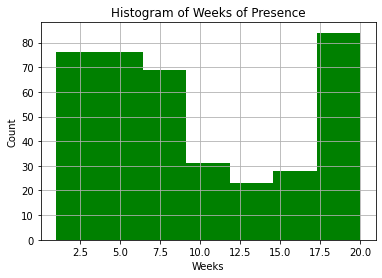

In [114]:
dfXmasSongsRaw['weeks_on_chart'].hist(bins=7,color="g")
plt.title('Histogram of Weeks of Presence')
plt.xlabel('Weeks')
plt.ylabel('Count')

In [115]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 3.0})

Text(0.5, 1.0, 'Weeks on Chart')

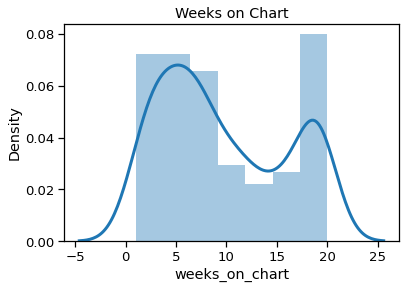

In [116]:
sns.distplot(dfXmasSongsRaw['weeks_on_chart']).set_title("Weeks on Chart")

Text(0.5, 1.0, 'Weeks on Chart')

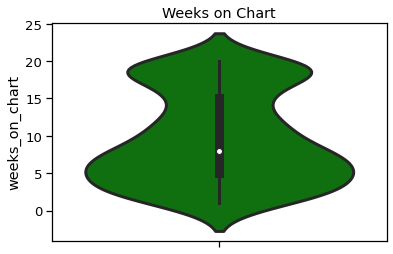

In [117]:
sns.violinplot(y=dfXmasSongsRaw['weeks_on_chart'], color='g').set_title("Weeks on Chart")


Do the same basic analysis on the number of weeks on the chart by season

In [118]:
sqlWoCPerSeason['weeksOnChartPerSeason'].describe()

count    106.000000
mean       3.650943
std        2.665628
min        1.000000
25%        1.250000
50%        3.000000
75%        5.000000
max       13.000000
Name: weeksOnChartPerSeason, dtype: float64

<AxesSubplot:>

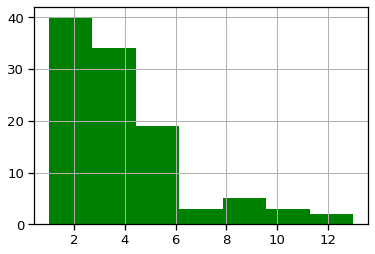

In [119]:
sqlWoCPerSeason['weeksOnChartPerSeason'].hist(bins=7,color="g")

Text(0.5, 1.0, 'Weeks on Chart per Season')

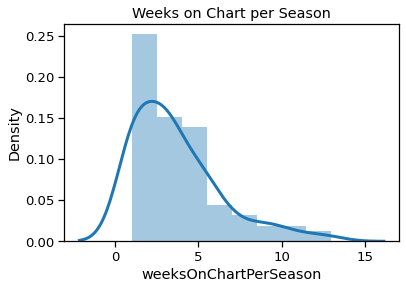

In [120]:
sns.distplot(sqlWoCPerSeason['weeksOnChartPerSeason']).set_title("Weeks on Chart per Season")

Text(0.5, 1.0, 'Weeks on Chart per Season')

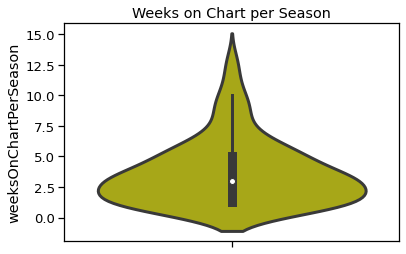

In [121]:
sns.violinplot(y=sqlWoCPerSeason['weeksOnChartPerSeason'], color='y').set_title("Weeks on Chart per Season")


Text(0.5, 1.0, 'Weeks on Chart globally over time')

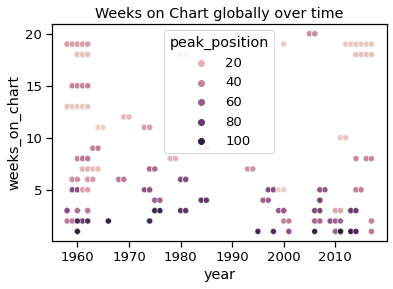

In [122]:
#Scatterplot of date vs weeks on chart
sns.scatterplot(data=dfXmasSongsRaw, x='year', y='weeks_on_chart',hue='peak_position').set_title("Weeks on Chart globally over time")


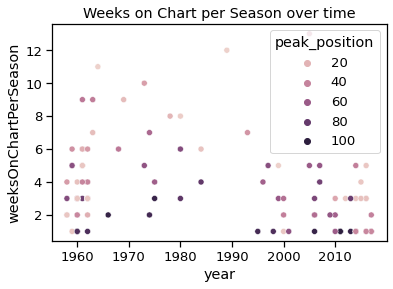

In [123]:
#Scatterplot of date vs weeks on chart
plot = sns.scatterplot(data=sqlWoCPerSeason, x='year', y='weeksOnChartPerSeason',hue='peak_position').set_title("Weeks on Chart per Season over time")


Text(0, 0.5, 'Count')

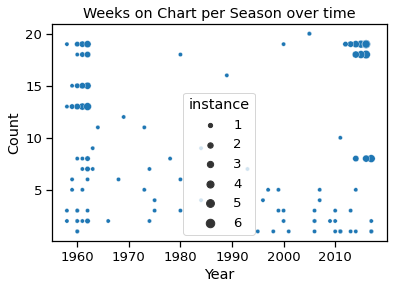

In [124]:
#Scatterplot of date vs weeks on chart
sns.scatterplot(data=sqlWoCPerSeason, x='year', y='weeks_on_chart',size='instance').set_title("Weeks on Chart per Season over time")
plt.xlabel('Year')
plt.ylabel('Count')


<AxesSubplot:xlabel='peak_position', ylabel='weeksOnChartPerSeason'>

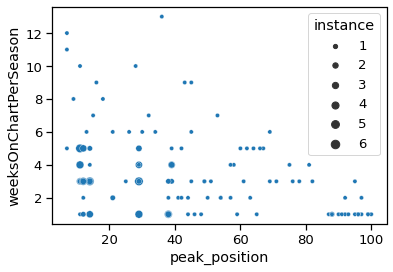

In [125]:
#Scatterplot of date vs weeks on chart
sns.scatterplot(data=sqlWoCPerSeason, x='peak_position', y='weeksOnChartPerSeason',size='instance')

Text(0.5, 0, 'Weeks on Chart')

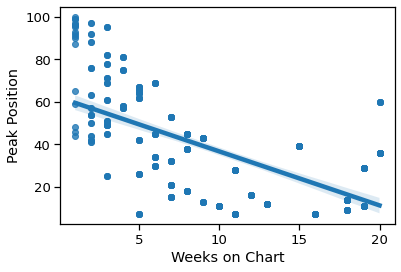

In [126]:
sns.regplot(x="weeks_on_chart",y="peak_position", data=dfXmasSongsRaw);
plt.ylabel('Peak Position')
plt.xlabel('Weeks on Chart')

Text(0.5, 0, 'Weeks on Chart per Season')

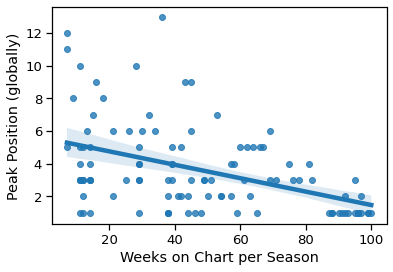

In [127]:
sns.regplot(x="peak_position",y="weeksOnChartPerSeason", data=sqlWoCPerSeason);
plt.ylabel('Peak Position (globally)')
plt.xlabel('Weeks on Chart per Season')

### Influence of performer type on WoC:    

Null Hypothesis H0: __There is no signifcant difference in the means of the songs performed by a group or an individual.__

Run independent t-test.


In [128]:
#split dataframe into 2 parts: one that contains songs performed by a group, 
#the other part performed by individuals
groupPerformer = dfXmasSongsRaw[dfXmasSongsRaw['performerGroup']==1]
individualPerformer = dfXmasSongsRaw[dfXmasSongsRaw['performerGroup']==0]

# t-test for independent samples
# calculate the t test
data1 = groupPerformer['weeks_on_chart']
data2 = individualPerformer['weeks_on_chart']
alpha = 0.05
t_stat, df, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))
# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis H0 that the means are equal.')
else:
    print('Reject the null hypothesis H0 that the means are equal.')

t=-1.298, df=385, cv=1.649, p=0.195
Accept null hypothesis H0 that the means are equal.
Accept null hypothesis H0 that the means are equal.


__With p=0.195 H0 is accepted!__

### Influence of decade on WoC.

Null Hypothesis H0: __There is no siginifcant influence of decade of the Song position on the weeks of presence in the Chart.__

Run ANOVA t-test with
IV: decade as categorical variable (ordinal) with 7 levels 
DV: weeks of presence as continuous variable

In [129]:
#Only Keep the 2 Varaibles that are necessary
xmasSongsDecadeVsWoC = dfXmasSongsRaw[['decade', 'weeks_on_chart']]


<AxesSubplot:xlabel='weeks_on_chart', ylabel='Density'>

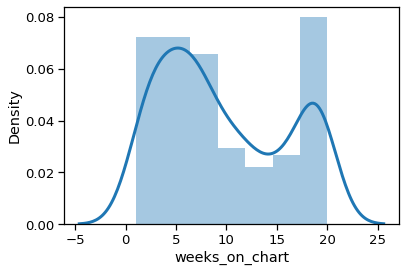

In [130]:
#Test for normality
sns.distplot(xmasSongsDecadeVsWoC['weeks_on_chart'])

Not really normally distributed...

<AxesSubplot:xlabel='weeks_on_chartLOG', ylabel='Density'>

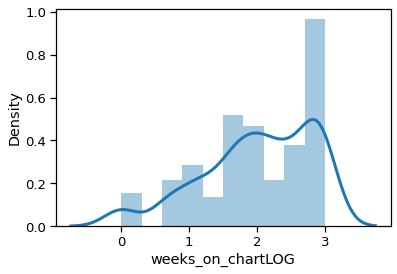

In [131]:
xmasSongsDecadeVsWoC['weeks_on_chartLOG'] = np.log(xmasSongsDecadeVsWoC['weeks_on_chart'])
sns.distplot(xmasSongsDecadeVsWoC['weeks_on_chartLOG'])

<AxesSubplot:xlabel='weeks_on_chartSQRT', ylabel='Density'>

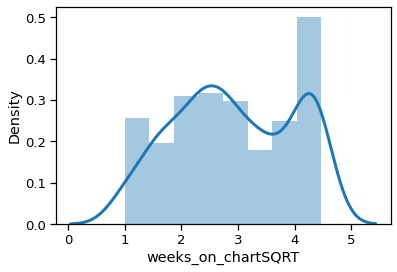

In [132]:
xmasSongsDecadeVsWoC['weeks_on_chartSQRT'] = np.sqrt(xmasSongsDecadeVsWoC['weeks_on_chart'])
sns.distplot(xmasSongsDecadeVsWoC['weeks_on_chartSQRT'])

<AxesSubplot:xlabel='weeks_on_chartCBRT', ylabel='Density'>

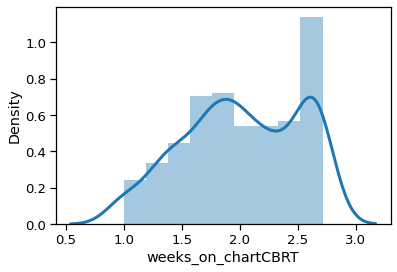

In [133]:
xmasSongsDecadeVsWoC['weeks_on_chartCBRT'] = np.cbrt(xmasSongsDecadeVsWoC['weeks_on_chart'])
sns.distplot(xmasSongsDecadeVsWoC['weeks_on_chartCBRT'])


Neither datawrangling really leads to a normally-like distribution - but the cube-root does so the most. Go further with this.

In [134]:
xmasSongsDecadeVsWoC.drop(['weeks_on_chartSQRT', 'weeks_on_chartLOG'], axis=1,inplace=True)
#Test for Homogeneity of Variance
scipy.stats.bartlett(xmasSongsDecadeVsWoC['weeks_on_chartCBRT'], xmasSongsDecadeVsWoC['decade'])

BartlettResult(statistic=2335.1791198158403, pvalue=0.0)

_Unfortunately there is a violation of assumption of Homogeneity of Variance!_

In [135]:
#Recode decade information
def recode (dec): 
    if dec == 1950: 
        return "1950ies"
    if dec == 1960: 
        return "1960ies"
    if dec == 1970: 
        return "1970ies"
    if dec == 1980: 
        return "1980ies"
    if dec == 1990: 
        return "1990ies"
    if dec == 2000: 
        return "2000ies"
    if dec == 2010: 
        return "2010ies"

xmasSongsDecadeVsWoC['decadeR'] = xmasSongsDecadeVsWoC['decade'].apply(recode)

In [136]:
#PostHoc
postHoc = MultiComparison(xmasSongsDecadeVsWoC['weeks_on_chart'], xmasSongsDecadeVsWoC['decadeR'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
1950ies 1960ies   0.0387    0.9 -4.1729 4.2503  False
1950ies 1970ies  -2.1981 0.7978 -6.9801  2.584  False
1950ies 1980ies      1.2    0.9 -3.7767 6.1767  False
1950ies 1990ies  -3.0238 0.6216 -8.4113 2.3637  False
1950ies 2000ies  -0.2171    0.9 -4.9056 4.4713  False
1950ies 2010ies   0.7371    0.9 -3.7564 5.2305  False
1960ies 1970ies  -2.2367 0.3344 -5.3425  0.869  False
1960ies 1980ies   1.1613    0.9 -2.2365 4.5592  False
1960ies 1990ies  -3.0625 0.2545 -7.0377 0.9127  False
1960ies 2000ies  -0.2558    0.9 -3.2154 2.7037  False
1960ies 2010ies   0.6984    0.9 -1.9415 3.3382  False
1970ies 1980ies   3.3981 0.1748 -0.6856 7.4817  False
1970ies 1990ies  -0.8258    0.9  -5.401 3.7495  False
1970ies 2000ies   1.9809 0.6732  -1.746 5.7078  False
1970ies 2010ies   2.9351 0.1618 -0.5433 6.4135  False
1980ies 1990ies  -4.2238 0.1

Because of violation of the assumption of homegeineity run Welch's ANOVA

#Source: https://www.statology.org/welchs-anova-in-python/

In [137]:
import pingouin as pg
pg.welch_anova(dv='weeks_on_chartCBRT', between='decade', data=xmasSongsDecadeVsWoC)

,Source,ddof1,ddof2,F,p-unc,np2
0,decade,6,104.169835,2.545635,0.024323,0.027191


__The overall p-value (0.024323) from the ANOVA table is less than α = .05, which means reject the null hypothesis that the weeks on charts are not being significantly influenced by decades.__

In [138]:
#Perform a Games-Howell post-hoc test to determine exactly which group means are different:
pg.pairwise_gameshowell(dv='weeks_on_chartCBRT', between='decade', data=xmasSongsDecadeVsWoC)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1950,1960,2.031489,2.066530,-0.035041,0.115885,-0.302381,24.242897,0.900000,-0.070307
1,1950,1970,2.031489,1.927808,0.103681,0.119317,0.868957,26.931311,0.900000,0.227718
2,1950,1980,2.031489,2.148121,-0.116632,0.132318,-0.881455,37.108025,0.900000,-0.239910
3,1950,1990,2.031489,1.813400,0.218089,0.138072,1.579533,38.322909,0.672758,0.463695
4,1950,2000,2.031489,1.937693,0.093796,0.142300,0.659142,46.837971,0.900000,0.169531
5,1950,2010,2.031489,2.012137,0.019352,0.135717,0.142594,42.412082,0.900000,0.035234
6,1960,1970,2.066530,1.927808,0.138723,0.057344,2.419148,99.855174,0.201557,0.415027
7,1960,1980,2.066530,2.148121,-0.081591,0.080992,-1.007394,51.046900,0.900000,-0.189044
8,1960,1990,2.066530,1.813400,0.253131,0.090087,2.809861,31.881580,0.104628,0.616713
9,1960,2000,2.066530,1.937693,0.128837,0.096441,1.335911,64.717113,0.811828,0.218429


Interpretation: Interestingly there is according to the p-value no significant difference between the means of the decades. The closest to a signifcant difference is between the 80ies and 90ies.

In [139]:
#Examine means
xmasSongsDecadeVsWoC.groupby('decadeR').mean()

,decade,weeks_on_chart,weeks_on_chartCBRT
decadeR,,,
1950ies,1950.0,9.857143,2.031489
1960ies,1960.0,9.895833,2.066530
1970ies,1970.0,7.659091,1.927808
1980ies,1980.0,11.057143,2.148121
1990ies,1990.0,6.833333,1.813400
2000ies,2000.0,9.640000,1.937693
2010ies,2010.0,10.594203,2.012137


### Influence of peak-position
Null Hypothesis H0: __There is no siginifcant influence of peak-position of the Song on the weeks of presence in the Chart.__

Run Linear Regression.   
IV: Peak-Position as continuous variable    
DV: weeks of presence as continuous variable

In [140]:
#extract only necessary data into a separate dataframe
dfPPvsWoC = dfXmasSongsRaw[['peak_position','weeks_on_chart']]
dfPPvsWoC[:4]

,peak_position,weeks_on_chart
0,49,3
1,49,3
2,49,3
3,96,1


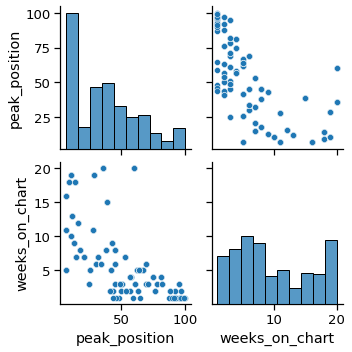

In [141]:
#Assumption Linearity
sns.pairplot(dfPPvsWoC)


<AxesSubplot:xlabel='peak_positionLOG', ylabel='Density'>

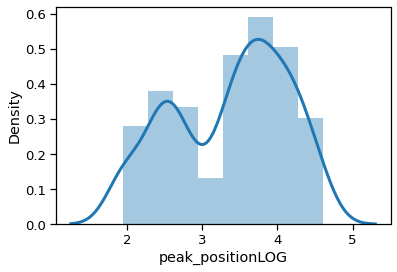

In [142]:
#need some data wrangling
dfPPvsWoC['peak_positionLOG'] = np.log(dfPPvsWoC['peak_position'])
sns.distplot(dfPPvsWoC['peak_positionLOG'])

<AxesSubplot:xlabel='peak_positionSQRT', ylabel='Density'>

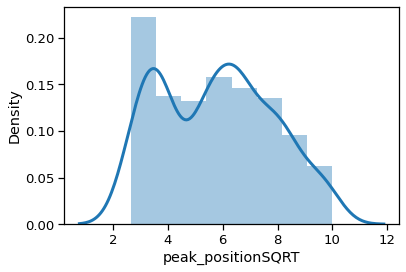

In [143]:
dfPPvsWoC['peak_positionSQRT'] = np.sqrt(dfPPvsWoC['peak_position'])
sns.distplot(dfPPvsWoC['peak_positionSQRT'])

<AxesSubplot:xlabel='peak_positionCBRT', ylabel='Density'>

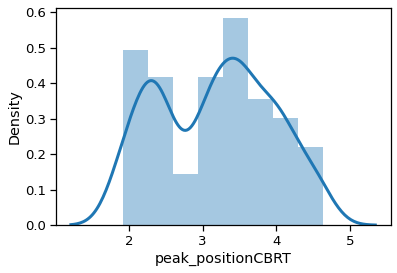

In [144]:
dfPPvsWoC['peak_positionCBRT'] = np.cbrt(dfPPvsWoC['peak_position'])
sns.distplot(dfPPvsWoC['peak_positionCBRT'])

Keep SQRT

In [145]:
dfPPvsWoC.drop(['peak_positionLOG', 'peak_positionCBRT'], axis=1,inplace=True)

Text(0.5, 1.0, 'Test for Homoscedasticity')

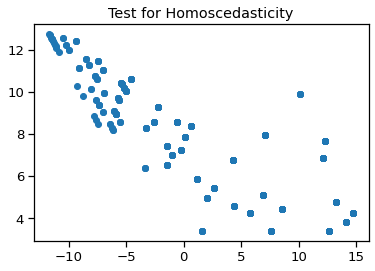

In [146]:
#Testing for Homoscedasticity
x = dfPPvsWoC['peak_positionSQRT']
y = dfPPvsWoC['weeks_on_chart']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfPPvsWoC['weeks_on_chart'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)
plt.title('Test for Homoscedasticity')

In [147]:
sms.diagnostic.het_breuschpagan(residual, dfPPvsWoC[['peak_positionSQRT']])

(147.6126091376583, nan, 238.0178292677964, 3.582541644447623e-42)

_Violation of the assumption of homoscedasticity, since this p-value is significant!_

In [148]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=3.043024111303093, pvalue=0.0025036656696115936)

Still violation of the assumption of homoscedasticity, although less strong. Fix the problem:

(array([36., 68., 24., 11., 49., 52., 50., 41., 34., 22.]),
 array([1.27045831, 1.59160458, 1.91275085, 2.23389712, 2.55504339,
        2.87618966, 3.19733593, 3.51848221, 3.83962848, 4.16077475,
        4.48192102]),
 <BarContainer object of 10 artists>)

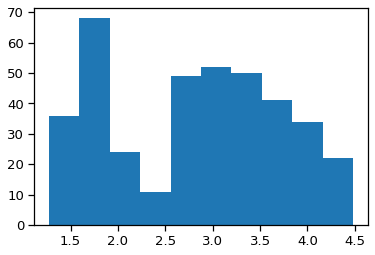

In [149]:
transformed, _ = boxcox(dfPPvsWoC['peak_positionSQRT'])
plt.hist(transformed)

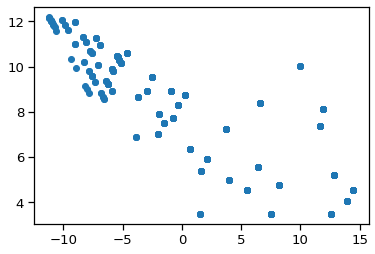

In [150]:
x = transformed
model1 = sm.OLS(y,x).fit()
pred_val = model1.fittedvalues.copy()
true_val = dfPPvsWoC['weeks_on_chart'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,4))
_ = ax.scatter(residual, pred_val)

In [151]:
sms.diagnostic.het_breuschpagan(residual, dfPPvsWoC[['peak_positionSQRT']])

(149.34218659833198, nan, 242.5591786857345, 8.78829037643179e-43)

In [152]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=3.043024111303093, pvalue=0.0025036656696115936)

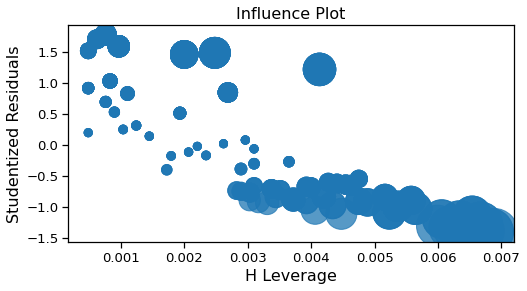

In [153]:
#Screening for outliers
fig, ax = plt.subplots(figsize=(8,4))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

Looks like there are no outliers, at least none labelled!

In [154]:
infl = model.get_influence()
infl.summary_frame()[:5]

,dfb_peak_positionSQRT,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.041336,0.001711,-0.710958,0.003373,-0.041362,-0.710502,-0.041336
1,-0.041336,0.001711,-0.710958,0.003373,-0.041362,-0.710502,-0.041336
2,-0.041336,0.001711,-0.710958,0.003373,-0.041362,-0.710502,-0.041336
3,-0.112772,0.012688,-1.380982,0.006609,-0.112639,-1.382611,-0.112772
4,-0.054103,0.002928,-0.939762,0.003304,-0.054111,-0.939619,-0.054103


In [155]:
infl.summary_frame()['dfb_peak_positionSQRT'][:5]
# --> no problems here!

0   -0.041336
1   -0.041336
2   -0.041336
3   -0.112772
4   -0.054103
Name: dfb_peak_positionSQRT, dtype: float64

In [156]:
infl.summary_frame()['dffits'].sort_values(ascending=False)[:5]
# --> no problem here

106    0.078223
105    0.078223
104    0.078223
103    0.078223
102    0.078223
Name: dffits, dtype: float64

In [157]:
infl.summary_frame()['hat_diag'].sort_values(ascending=False)[:5]
# --> no problem here

252    0.006884
282    0.006815
372    0.006815
336    0.006678
363    0.006678
Name: hat_diag, dtype: float64

In [158]:
infl.summary_frame()['student_resid'].sort_values(ascending=False)[:5]
# --> no problem here

264    1.773563
260    1.773563
266    1.773563
265    1.773563
268    1.773563
Name: student_resid, dtype: float64

In [159]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         weeks_on_chart   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                              338.7
Date:                Sat, 01 Jan 2022   Prob (F-statistic):                    9.42e-55
Time:                        17:49:04   Log-Likelihood:                         -1370.1
No. Observations:                 387   AIC:                                      2742.
Df Residuals:                     386   BIC:                                      2746.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
peak_positionSQRT     1.2756      0.069     18.404      0.000       1.139       1.412
==============================================================================
Omnibus:                      518.565   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.467
Skew:                           0.052   Prob(JB):                     1.09e-06
Kurtosis:                       1.699   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation: __With p-value = 9.42e-55 reject H0 that peak-position has no significant influence on the weeks on the Chart of the song!__

In [160]:
sqlPPvsWoC = sqldf("select distinct songid,peak_position, weeks_on_chart from dfXmasSongsRaw order by songid;")
sqlPPvsWoC[:5]

,songid,peak_position,weeks_on_chart
0,A Great Big SledThe Killers Featuring Toni Hal...,54,2
1,A Holly Jolly ChristmasBurl Ives,46,1
2,All I Want For Christmas Is YouMariah Carey,11,19
3,All I Want For Christmas Is YouMichael Buble,99,1
4,AmenThe Impressions,7,11


Create a Scatterplot of peak-position vs weeks on chart:

Text(0.5, 0, 'Weeks on Chart (globally)')

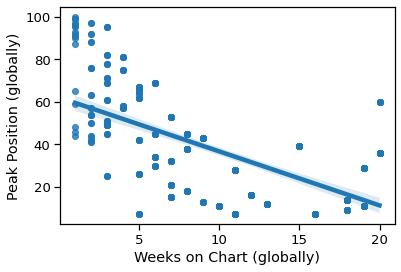

In [161]:
sns.regplot(x="weeks_on_chart",
            y="peak_position", 
            data=dfXmasSongsRaw);
plt.ylabel('Peak Position (globally)')
plt.xlabel('Weeks on Chart (globally)')

__The plot confirms what could be expected: There is a negative slope of the linear regression, i.e. a negative correlation between the number of weeks of a song on the chart and its peak position. In other words: the better a song was placed, the longer it stayed on the chart.__

### Influence of (month of) first appearance
Null Hypothesis H0: __There is no signifcant influence of the month of first appearance on the chart of the Song on the weeks of presence in the Chart.__

Run ANOVA.   
IV: Month of first appearance as categorical variable (3 Levels) 
DV: weeks of presence as continuous variable

In [162]:
sqlMofavsWoC = sqldf("select distinct date, songid,month, weeks_on_chart from dfXmasSongsRaw order by date;")
sqlMofavsWoC[-30:-25]

,date,songid,month,weeks_on_chart
357,2014-12-27 00:00:00.000000,Have Yourself A Merry Little ChristmasSam Smith,12,1
358,2015-01-03 00:00:00.000000,Santa Tell MeAriana Grande,1,5
359,2015-01-03 00:00:00.000000,All I Want For Christmas Is YouMariah Carey,1,19
360,2015-01-10 00:00:00.000000,Santa Tell MeAriana Grande,1,5
361,2015-12-19 00:00:00.000000,All I Want For Christmas Is YouMariah Carey,12,19


In [163]:
dfMofavsWoC = sqlMofavsWoC[['month','weeks_on_chart']]

<AxesSubplot:xlabel='weeks_on_chart', ylabel='Density'>

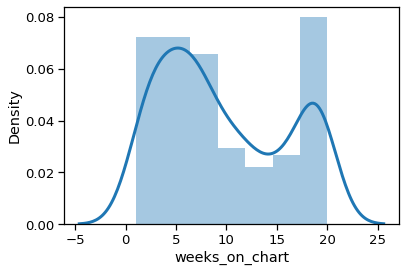

In [164]:
#Test for normality
#dfPPvsWoC['peak_positionSQRT'] = np.sqrt(dfPPvsWoC['peak_position'])
sns.distplot(dfMofavsWoC['weeks_on_chart'])


<AxesSubplot:xlabel='weeks_on_chartCBRT', ylabel='Density'>

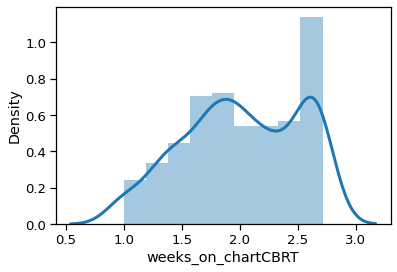

In [165]:
#as done already prior to this analysis let's go with cube root
dfMofavsWoC['weeks_on_chartCBRT'] = np.cbrt(dfMofavsWoC['weeks_on_chart'])
sns.distplot(dfMofavsWoC['weeks_on_chartCBRT'])

In [166]:
#Test for Homogeneity of Variance
scipy.stats.bartlett(dfMofavsWoC['weeks_on_chartCBRT'], dfMofavsWoC['month'])

BartlettResult(statistic=1297.2255112190692, pvalue=4.5306188055798135e-284)

Unfortunately there is a violation of assumption of Homogeneity of Variance!

In [167]:
#Recode month information
def recode (month): 
    if month == 11: 
        return "Nov"
    if month == 12: 
        return "Dec"
    if month == 1: 
        return "Jan"

dfMofavsWoC['monthR'] = dfMofavsWoC['month'].apply(recode)

In [168]:
#PostHoc
postHoc = MultiComparison(dfMofavsWoC['weeks_on_chart'], dfMofavsWoC['monthR'])
postHocResults = postHoc.tukeyhsd()
print(postHocResults)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Dec    Jan  -0.5321 0.6725 -2.051 0.9868  False
   Dec    Nov   4.1792 0.0283 0.3549 8.0035   True
   Jan    Nov   4.7113 0.0127 0.8258 8.5967   True
--------------------------------------------------


Because of violation of the assumption of homegeineity run Welch's ANOVA

#Source: https://www.statology.org/welchs-anova-in-python/

In [169]:
import pingouin as pg
pg.welch_anova(dv='weeks_on_chart', between='month', data=dfMofavsWoC)

,Source,ddof1,ddof2,F,p-unc,np2
0,month,2,40.701053,6.730975,0.002982,0.020819


__The overall p-value (0.002982) from the ANOVA table is less than α = .05, which means reject the null hypothesis that the month of first appearance on the chart does not influence significantly the number of weeks on the chart.__

In [170]:
#Perform a Games-Howell post-hoc test to determine exactly which group means are different:
pg.pairwise_gameshowell(dv='weeks_on_chart', between='month', data=dfMofavsWoC)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,11,9.155405,13.866667,-4.711261,1.277051,-3.689171,19.238816,0.004161,-0.994982
1,1,12,9.155405,9.687500,-0.532095,0.645030,-0.824914,324.378940,0.672241,-0.087205
2,11,12,13.866667,9.687500,4.179167,1.250446,3.342140,17.718434,0.009785,0.888538


The p-values in the table above show:
* __the mean difference between January and November are significantly different__
* __the mean difference between November and December are significantly different__

Also: the average duration of presence on the chart is longest if the song first appeared in November, then in December and finally in January - which was to be expected. Although the difference between December and January is minimal.


### Influence of time-to-christmas of first appearance on weeks on the Chart
Null Hypothesis H0: __There is no significant influence of of time-to-christmas of first appearance of the Song on the weeks of presence in the Chart.__

Run Linear Regression.   
IV: Days to Christmas as continuous variable    
DV: weeks of presence as continuous variable

In [171]:
# get the songs with the relevant information
sqlUniqueSongsT2Xmas = sqldf("""select distinct songid,date,numberOfDaysToXmas,weeks_on_chart 
                             from dfXmasSongsRaw 
                             group by songid order by 3 asc;""")
print(sqlUniqueSongsT2Xmas.info())
sqlUniqueSongsT2Xmas[:5]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   songid              78 non-null     object
 1   date                78 non-null     object
 2   numberOfDaysToXmas  78 non-null     int64 
 3   weeks_on_chart      78 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ KB
None


,songid,date,numberOfDaysToXmas,weeks_on_chart
0,Grandma Got Run Over By A ReindeerElmo & Patsy,1998-01-10 00:00:00.000000,-16,1
1,All I Want For Christmas Is YouMariah Carey,2000-01-08 00:00:00.000000,-14,19
2,Shake Up ChristmasTrain,2011-01-08 00:00:00.000000,-14,1
3,A Holly Jolly ChristmasBurl Ives,2017-01-07 00:00:00.000000,-13,1
4,Feliz NavidadJose Feliciano,2017-01-07 00:00:00.000000,-13,1


In [172]:
#extract only necessary data into a separate dataframe
dfUniqueSongsT2Xmas = sqlUniqueSongsT2Xmas[['numberOfDaysToXmas','weeks_on_chart']]
dfUniqueSongsT2Xmas[:4]

,numberOfDaysToXmas,weeks_on_chart
0,-16,1
1,-14,19
2,-14,1
3,-13,1


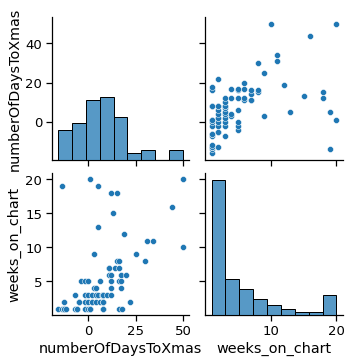

In [173]:
#Assumption Linearity
sns.pairplot(dfUniqueSongsT2Xmas)

<AxesSubplot:xlabel='numberOfDaysToXmasLOG', ylabel='Density'>

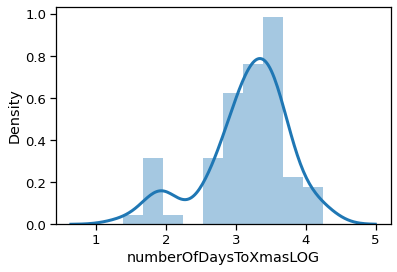

In [174]:
#need some data wrangling - try Log with adding 20 to avoid log on negative numbers = undefined!
dfUniqueSongsT2Xmas['numberOfDaysToXmasLOG'] = np.log(dfUniqueSongsT2Xmas['numberOfDaysToXmas']+20)
sns.distplot(dfUniqueSongsT2Xmas['numberOfDaysToXmasLOG'])

<AxesSubplot:xlabel='numberOfDaysToXmasSQRT', ylabel='Density'>

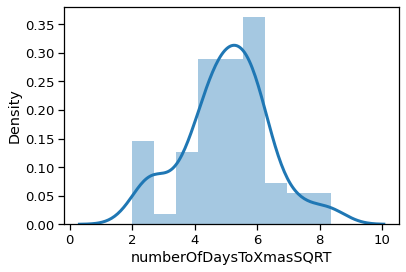

In [175]:
#need some data wrangling - try SQRT with adding 20 to avoid sqrt on negative numbers = undefined!
dfUniqueSongsT2Xmas['numberOfDaysToXmasSQRT'] = np.sqrt(dfUniqueSongsT2Xmas['numberOfDaysToXmas']+20)
sns.distplot(dfUniqueSongsT2Xmas['numberOfDaysToXmasSQRT'])

#SQRT looks better than log! --> Keep SQRT

<AxesSubplot:xlabel='weeks_on_chartCBRT', ylabel='Density'>

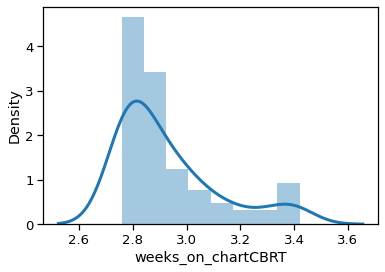

In [176]:
#as for weeks on chart - keep with cube root as explored in prior analysis
dfUniqueSongsT2Xmas['weeks_on_chartCBRT'] = np.cbrt(dfUniqueSongsT2Xmas['weeks_on_chart']+20)
sns.distplot(dfUniqueSongsT2Xmas['weeks_on_chartCBRT'])

In [177]:
dfUniqueSongsT2Xmas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numberOfDaysToXmas      78 non-null     int64  
 1   weeks_on_chart          78 non-null     int64  
 2   numberOfDaysToXmasLOG   78 non-null     float64
 3   numberOfDaysToXmasSQRT  78 non-null     float64
 4   weeks_on_chartCBRT      78 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 3.2 KB


In [178]:
dfUniqueSongsT2Xmas.drop(['numberOfDaysToXmasLOG'], axis=1,inplace=True)

Text(0.5, 1.0, 'Test for Homoscedasticity')

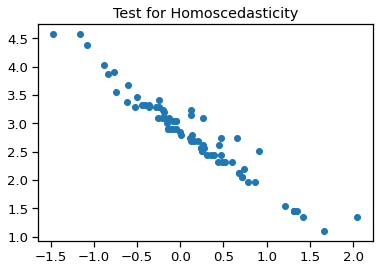

In [179]:
#Testing for Homoscedasticity
x = dfUniqueSongsT2Xmas['numberOfDaysToXmasSQRT']
y = dfUniqueSongsT2Xmas['weeks_on_chartCBRT']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfUniqueSongsT2Xmas['weeks_on_chartCBRT'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)
plt.title('Test for Homoscedasticity')

Looks fairly linear!

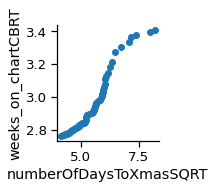

In [180]:
from seaborn_qqplot import pplot
pplot(dfUniqueSongsT2Xmas, x = "numberOfDaysToXmasSQRT", y = "weeks_on_chartCBRT", kind = 'qq')

In [181]:
sms.diagnostic.het_breuschpagan(residual, dfUniqueSongsT2Xmas[['numberOfDaysToXmasSQRT']])

(14.181343929027204, nan, 17.1104117473223, 8.919127906422687e-05)

_Violation of the assumption of homoscedasticity, since this p-value with 8.919e-05 is significant!_

In [182]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=-22.675055942190262, pvalue=4.836463533115069e-35)

Still violation of the assumption of homoscedasticity. Fix the problem:

(array([ 8.,  1.,  6.,  9., 17., 17., 13.,  2.,  2.,  3.]),
 array([1.01161627, 1.67894782, 2.34627936, 3.01361091, 3.68094246,
        4.348274  , 5.01560555, 5.6829371 , 6.35026864, 7.01760019,
        7.68493173]),
 <BarContainer object of 10 artists>)

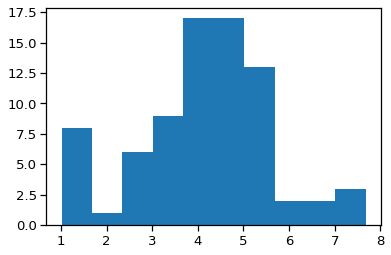

In [183]:
transformed, _ = boxcox(dfUniqueSongsT2Xmas['numberOfDaysToXmasSQRT'])
plt.hist(transformed)

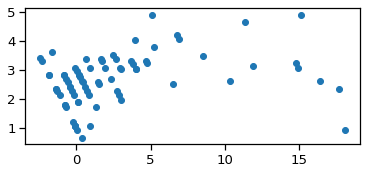

In [184]:
x = transformed
model1 = sm.OLS(y,x).fit()
pred_val = model1.fittedvalues.copy()
true_val = dfUniqueSongsT2Xmas['weeks_on_chart'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual, pred_val)

In [185]:
sms.diagnostic.het_breuschpagan(residual, dfUniqueSongsT2Xmas[['numberOfDaysToXmasSQRT']])

(13.641973241888072, nan, 16.321692763723227, 0.0001254620084345871)

Better - but still violation of homoscedasticity.

In [186]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=-22.675055942190262, pvalue=4.836463533115069e-35)

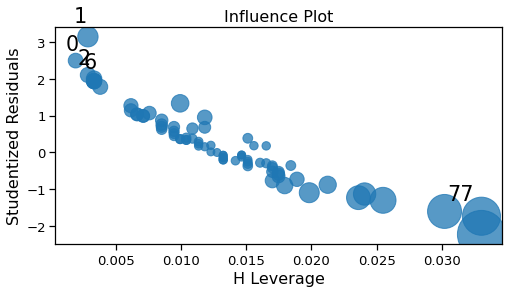

In [187]:
#Screening for outliers
fig, ax = plt.subplots(figsize=(8,4))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

Looks like there are a few outliers. Remove them! Keep on repeating this process until all outliers are identified and removed!

In [188]:
exclList=[0,1,2,3,4,5,6,7,8,9,10,24,70,72,73,74,75,76,77]
dfUniqueSongsT2XmasCleanedFromOutliers = dfUniqueSongsT2Xmas.drop(exclList)

Text(0.5, 1.0, 'Test for Homoscedasticity')

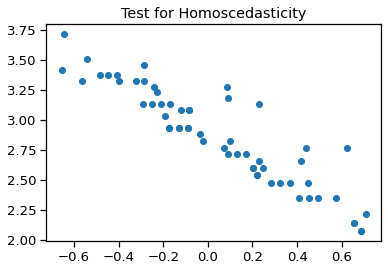

In [189]:
#re-create model:
#Testing for Homoscedasticity
x = dfUniqueSongsT2XmasCleanedFromOutliers['numberOfDaysToXmasSQRT']
y = dfUniqueSongsT2XmasCleanedFromOutliers['weeks_on_chartCBRT']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfUniqueSongsT2XmasCleanedFromOutliers['weeks_on_chartCBRT'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)
plt.title('Test for Homoscedasticity')

In [190]:
sms.diagnostic.het_breuschpagan(residual, dfUniqueSongsT2XmasCleanedFromOutliers[['numberOfDaysToXmas']])
# --> p-Value = 0.0057, still < 0.05, assumption of Homoscedasticity not met

(7.334163019210957, nan, 8.2333216680958, 0.00572904828315419)

In [191]:
# Testing for Multicollinearity:
dfUniqueSongsT2XmasCleanedFromOutliers.corr()

,numberOfDaysToXmas,weeks_on_chart,numberOfDaysToXmasSQRT,weeks_on_chartCBRT
numberOfDaysToXmas,1.000000,0.401677,0.997158,0.423257
weeks_on_chart,0.401677,1.000000,0.403531,0.997900
numberOfDaysToXmasSQRT,0.997158,0.403531,1.000000,0.424786
weeks_on_chartCBRT,0.423257,0.997900,0.424786,1.000000


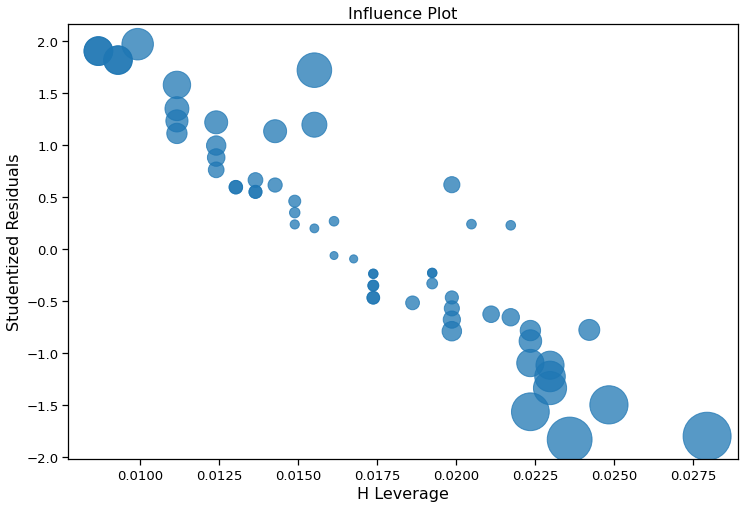

In [192]:
#Screening for Outliers
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

In [193]:
infl = model.get_influence()
infl.summary_frame()[:5]

,dfb_numberOfDaysToXmasSQRT,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
11,0.178393,0.030444,1.863532,0.008690,0.174481,1.905318,0.178393
12,0.178393,0.030444,1.863532,0.008690,0.174481,1.905318,0.178393
13,0.176324,0.029900,1.783643,0.009311,0.172917,1.818785,0.176324
14,0.176324,0.029900,1.783643,0.009311,0.172917,1.818785,0.176324
15,0.197487,0.037151,1.924450,0.009932,0.192746,1.971779,0.197487


In [194]:
infl.summary_frame()['dfb_numberOfDaysToXmasSQRT'].sort_values(ascending=False)[:5]
# --> no problem here


36    0.216206
15    0.197487
11    0.178393
12    0.178393
13    0.176324
Name: dfb_numberOfDaysToXmasSQRT, dtype: float64

In [195]:
infl.summary_frame()['dffits'].sort_values(ascending=False)[:5]
# --> no problem here

36    0.216206
15    0.197487
11    0.178393
12    0.178393
13    0.176324
Name: dffits, dtype: float64

In [196]:
infl.summary_frame()['hat_diag'].sort_values(ascending=False)[:5]
# --> no problem here

71    0.027933
69    0.024829
68    0.024209
67    0.023588
66    0.022967
Name: hat_diag, dtype: float64

In [197]:
infl.summary_frame()['student_resid'].sort_values(ascending=False)[:5]
# --> no problem here

15    1.971779
11    1.905318
12    1.905318
14    1.818785
13    1.818785
Name: student_resid, dtype: float64

In [198]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     weeks_on_chartCBRT   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              3612.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):                    6.09e-54
Time:                        17:49:07   Log-Likelihood:                         -24.538
No. Observations:                  59   AIC:                                      51.08
Df Residuals:                      58   BIC:                                      53.15
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
numberOfDaysToXmasSQRT     0.5539      0.009     60.103      0.000       0.535       0.572
==============================================================================
Omnibus:                        3.751   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                1.863
Skew:                           0.073   Prob(JB):                        0.394
Kurtosis:                       2.142   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation:

In this model (exclusion of outliers!):
* __The number of days to (or from) Christmas explains 98.4% (!) of the variability in number of weeks on chart (R-squared value).__
* __Reject H0: p-value = 6.09e-54; The number of days to (or from) Christmas significantly influence the number of weeks on chart.__

Create a Scatterplot of the dataset without the detected outliers:

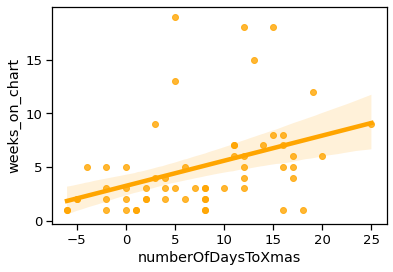

In [199]:
sns.regplot(y="weeks_on_chart", x="numberOfDaysToXmas", data=dfUniqueSongsT2XmasCleanedFromOutliers,color="orange");


__The plot confirms what could be expected: There is a slight positive slope of the linear regression, i.e. a positive correlation between the number of weeks of a song on the chart and the number of days to or from Christmas. In other words: The further ahead from Christmas the song first appeared in the chart, the longer it stayed on the chart.__

Run another linear regression model...

In [200]:
y = dfUniqueSongsT2Xmas['weeks_on_chart'] # dependent variable
x = dfUniqueSongsT2Xmas['numberOfDaysToXmas'] # independent variable
lm = sm.OLS(y,x).fit() # fitting the model
lm.predict(x)

0     -4.912945
1     -4.298827
2     -4.298827
3     -3.991768
4     -3.991768
        ...    
73     9.518831
74    10.440009
75    13.510599
76    15.352954
77    15.352954
Length: 78, dtype: float64

In [201]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         weeks_on_chart   R-squared (uncentered):                   0.398
Model:                            OLS   Adj. R-squared (uncentered):              0.390
Method:                 Least Squares   F-statistic:                              50.89
Date:                Sat, 01 Jan 2022   Prob (F-statistic):                    4.64e-10
Time:                        17:49:07   Log-Likelihood:                         -248.20
No. Observations:                  78   AIC:                                      498.4
Df Residuals:                      77   BIC:                                      500.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
numberOfDaysToXmas     0.3071      0.043      7.134      0.000       0.221       0.393
==============================================================================
Omnibus:                       41.875   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.612
Skew:                           1.817   Prob(JB):                     5.80e-25
Kurtosis:                       7.597   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation:
* __The number of days to (or from) Christmas explains 39.8% of the variability in number of weeks on chart (R-squared value).__
* __Reject H0: p-value = 4.64e-10; The number of days to (or from) Christmas significantly influence the number of weeks on chart.__

Create a Scatterplot of days to Christmas versus weeks on chart:

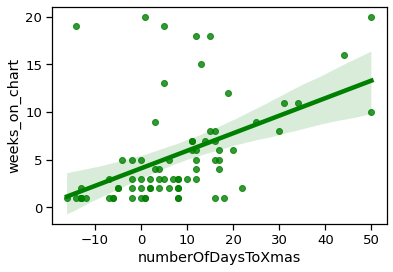

In [202]:
sns.regplot(y="weeks_on_chart", x="numberOfDaysToXmas", data=dfUniqueSongsT2Xmas,color="green");

### Influence of instances of a song
Null Hypothesis H0: __There is no significant influence of instances of a Song on the weeks of presence in the Chart.__

Run Linear Regression.   
IV: Instance as continuous variable    
DV: weeks of presence as continuous variable

In [203]:
# get the songs with the relevant information
sqlUniqueSongsInstance = sqldf("select songid,max(instance) as maxinstance,weeks_on_chart from dfXmasSongsRaw group by songid order by instance desc;")
print(sqlUniqueSongsInstance.info())
sqlUniqueSongsInstance[:5]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   songid          78 non-null     object
 1   maxinstance     78 non-null     int64 
 2   weeks_on_chart  78 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ KB
None


,songid,maxinstance,weeks_on_chart
0,Rockin' Around The Christmas TreeBrenda Lee,6,18
1,Jingle Bell RockBobby Helms,6,19
2,All I Want For Christmas Is YouMariah Carey,6,19
3,White ChristmasBing Crosby,5,13
4,The Christmas Song (Merry Christmas To You)Nat...,5,8


In [204]:
#extract only necessary data into a separate dataframe
dfUniqueSongsMaxInstance = sqlUniqueSongsInstance[['maxinstance','weeks_on_chart']]
dfUniqueSongsMaxInstance[:4]

,maxinstance,weeks_on_chart
0,6,18
1,6,19
2,6,19
3,5,13


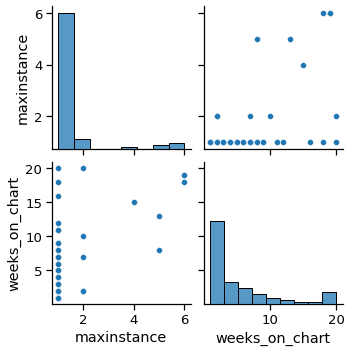

In [205]:
#Assumption Linearity
sns.pairplot(sqlUniqueSongsInstance)

<AxesSubplot:xlabel='weeks_on_chartCBRT', ylabel='Density'>

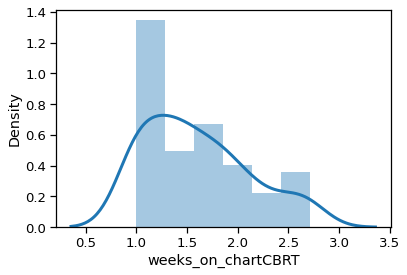

In [206]:
#need some data wrangling - try Log 
dfUniqueSongsMaxInstance['weeks_on_chartCBRT'] = np.cbrt(dfUniqueSongsMaxInstance['weeks_on_chart'])
sns.distplot(dfUniqueSongsMaxInstance['weeks_on_chartCBRT'])

<AxesSubplot:xlabel='maxinstanceLOG', ylabel='Density'>

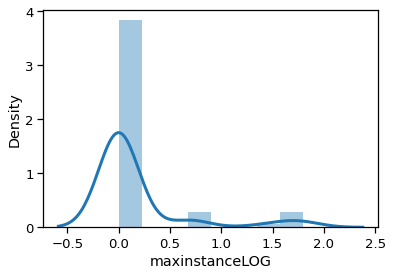

In [207]:
#need some data wrangling - try Log 
dfUniqueSongsMaxInstance['maxinstanceLOG'] = np.log(dfUniqueSongsMaxInstance['maxinstance'])
sns.distplot(dfUniqueSongsMaxInstance['maxinstanceLOG'])

<AxesSubplot:xlabel='maxinstanceSQRT', ylabel='Density'>

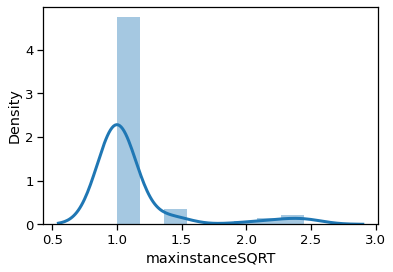

In [208]:
#need some data wrangling - try sqrt 
dfUniqueSongsMaxInstance['maxinstanceSQRT'] = np.sqrt(dfUniqueSongsMaxInstance['maxinstance'])
sns.distplot(dfUniqueSongsMaxInstance['maxinstanceSQRT'])

SQRT is better - keep it!

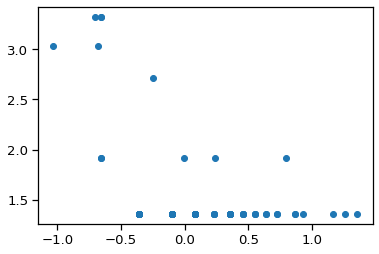

In [209]:
#Testing for Homoscedasticity
x = dfUniqueSongsMaxInstance['maxinstanceSQRT']
y = dfUniqueSongsMaxInstance['weeks_on_chartCBRT']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfUniqueSongsMaxInstance['weeks_on_chartCBRT'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)

In [210]:
sms.diagnostic.het_breuschpagan(residual, dfUniqueSongsMaxInstance[['maxinstanceSQRT']])
# --> p-Value = 7.101e-09, still < 0.05, assumption of Homoscedasticity not met

(27.658842963597795, nan, 42.305958654406766, 7.100955999260789e-09)

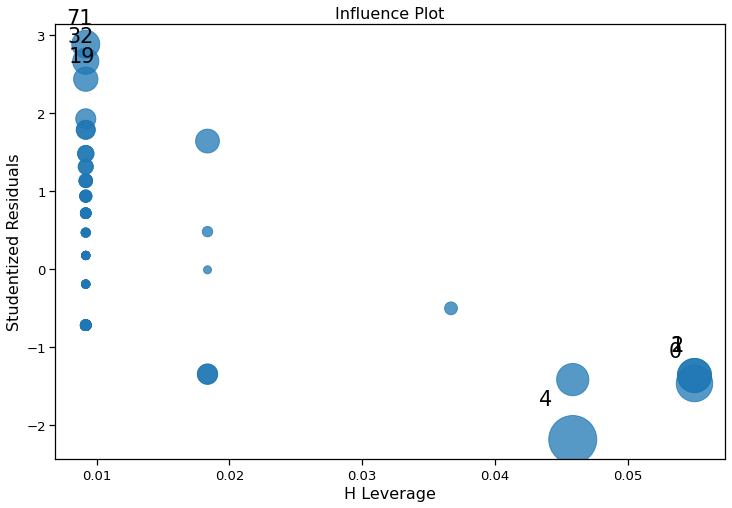

In [211]:
#Screening for Outliers
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

In [212]:
#Looks like there are a few outliers. Remove them! Keep on repeating this process until all outliers are identified and removed!
exclList=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,19,24,32,36,67,70,71,72,73,74,75,76,77]
exclList=[0,1,2,3,4,6,9,10,11,19,23,32,52,60,63,71,75]
dfUniqueSongsMaxInstanceCleanedFromOutliers = dfUniqueSongsMaxInstance.drop(exclList)


In [213]:
# Testing for Multicollinearity:
dfUniqueSongsMaxInstanceCleanedFromOutliers.corr()

,maxinstance,weeks_on_chart,weeks_on_chartCBRT,maxinstanceLOG,maxinstanceSQRT
maxinstance,1.000000,0.653350,0.472139,0.984228,0.995889
weeks_on_chart,0.653350,1.000000,0.961911,0.658188,0.658418
weeks_on_chartCBRT,0.472139,0.961911,1.000000,0.487389,0.481820
maxinstanceLOG,0.984228,0.658188,0.487389,1.000000,0.996206
maxinstanceSQRT,0.995889,0.658418,0.481820,0.996206,1.000000


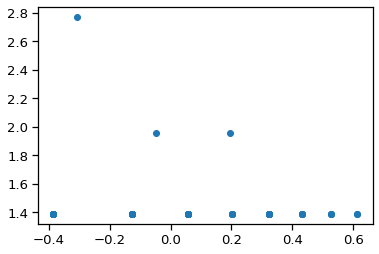

In [214]:
#re-create model:
#Testing for Homoscedasticity
x = dfUniqueSongsMaxInstanceCleanedFromOutliers['maxinstanceSQRT']
y = dfUniqueSongsMaxInstanceCleanedFromOutliers['weeks_on_chartCBRT']
model = sm.OLS(y,x).fit()
pred_val = model.fittedvalues.copy()
true_val = dfUniqueSongsMaxInstanceCleanedFromOutliers['weeks_on_chartCBRT'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.scatter(residual, pred_val)

In [215]:
sms.diagnostic.het_breuschpagan(residual, dfUniqueSongsMaxInstanceCleanedFromOutliers[['maxinstanceSQRT']])
# --> p-Value = 1.125e-11, still < 0.05, assumption of Homoscedasticity not met

(31.48240498463831, nan, 63.99384157466913, 4.9076794700324825e-11)

In [216]:
# Testing for Multicollinearity:
dfUniqueSongsMaxInstanceCleanedFromOutliers.corr()

,maxinstance,weeks_on_chart,weeks_on_chartCBRT,maxinstanceLOG,maxinstanceSQRT
maxinstance,1.000000,0.653350,0.472139,0.984228,0.995889
weeks_on_chart,0.653350,1.000000,0.961911,0.658188,0.658418
weeks_on_chartCBRT,0.472139,0.961911,1.000000,0.487389,0.481820
maxinstanceLOG,0.984228,0.658188,0.487389,1.000000,0.996206
maxinstanceSQRT,0.995889,0.658418,0.481820,0.996206,1.000000


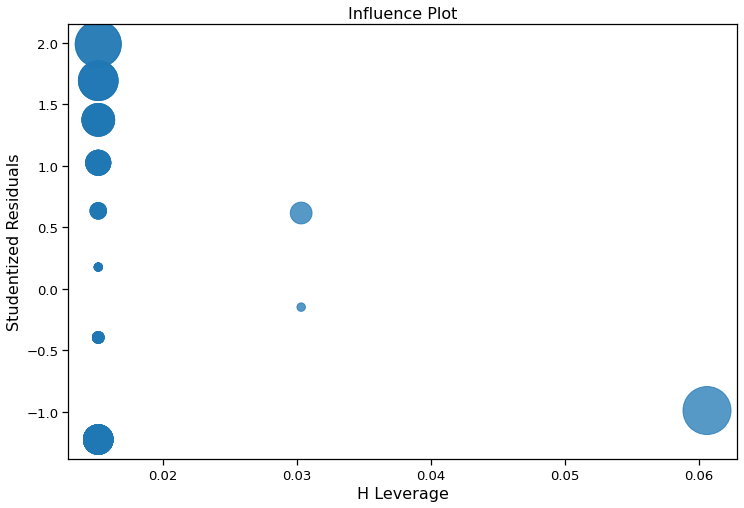

In [217]:
#Screening for Outliers
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, alpha = .05, ax = ax, criterion="cooks")

In [218]:
infl = model.get_influence()
infl.summary_frame()[:5]

,dfb_maxinstanceSQRT,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
5,-0.251524,0.063285,-0.990412,0.060606,-0.251565,-0.990252,-0.251524
7,0.108966,0.011998,0.619616,0.030303,0.109534,0.616407,0.108966
8,-0.026357,0.000706,-0.150326,0.030303,-0.026574,-0.149096,-0.026357
12,-0.152090,0.022939,-1.221075,0.015152,-0.151456,-1.226188,-0.152090
13,0.209953,0.042751,1.666986,0.015152,0.206764,1.692699,0.209953


In [219]:
infl.summary_frame()['dfb_maxinstanceSQRT'].sort_values(ascending=False)[:5]
# --> no problem here


36    0.246798
44    0.246798
13    0.209953
45    0.209953
35    0.209953
Name: dfb_maxinstanceSQRT, dtype: float64

In [220]:
infl.summary_frame()['dffits'].sort_values(ascending=False)[:5]
# --> no problem here

36    0.246798
44    0.246798
13    0.209953
45    0.209953
35    0.209953
Name: dffits, dtype: float64

In [221]:
infl.summary_frame()['hat_diag'].sort_values(ascending=False)[:5]
# --> no problem here

5     0.060606
8     0.030303
7     0.030303
76    0.015152
74    0.015152
Name: hat_diag, dtype: float64

In [222]:
infl.summary_frame()['student_resid'].sort_values(ascending=False)[:5]
# --> no problem here

44    1.989751
36    1.989751
45    1.692699
13    1.692699
35    1.692699
Name: student_resid, dtype: float64

In [223]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     weeks_on_chartCBRT   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              1250.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):                    7.10e-42
Time:                        17:49:08   Log-Likelihood:                         -16.264
No. Observations:                  61   AIC:                                      34.53
Df Residuals:                      60   BIC:                                      36.64
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
maxinstanceSQRT     1.3860      0.039     35.350      0.000       1.308       1.464
==============================================================================
Omnibus:                       13.781   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.836
Skew:                           0.210   Prob(JB):                        0.147
Kurtosis:                       1.845   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation:
* __The (max) number of instances explains 95.4% of the variability in number of weeks on chart (R-squared value).__
* __Reject H0: p-value = 7.10e-42; The (max) number of instances significantly influence the number of weeks on chart.__

Create a Scatterplot of days to Christmas versus weeks on chart:

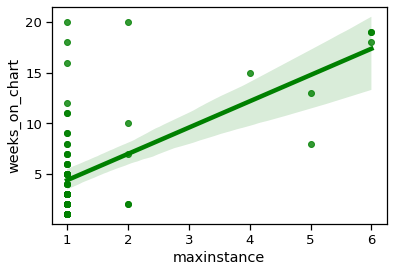

In [224]:
sns.regplot(y="weeks_on_chart", x="maxinstance", data=dfUniqueSongsMaxInstance,color="green");

#### Get some statistics on song counts per season

In [225]:
sqlSongsPerSeason = sqldf("""select count(*) as seasonCount, sum(weeksOnChartPerSeason) as seasonSum ,season 
                            from dfXmasSongsRaw 
                            group by season
                            order by season;""")
sqlSongsPerSeason

,seasonCount,seasonSum,season
0,11,33,1958
1,17,87,1959
2,26,72,1960
3,43,253,1961
4,29,109,1962
5,16,130,1963
6,11,121,1964
7,2,4,1966
8,6,36,1968
9,9,81,1969


[Text(0.5, 1.0, 'Count of Songs in the Chart')]

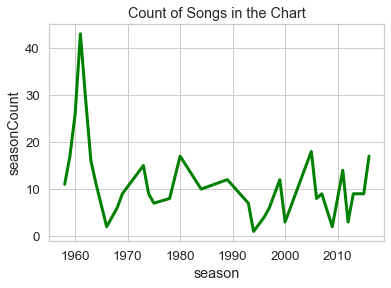

In [226]:
#Plot the result: Counts of songs per season
sns.set_style("whitegrid")
sns.lineplot(data=sqlSongsPerSeason, x="season", y="seasonCount",color='g').set(title='Count of Songs in the Chart')



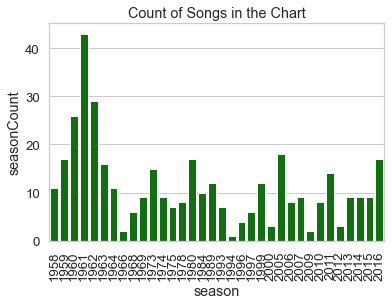

In [227]:
sns.barplot(data=sqlSongsPerSeason, x="season", y="seasonCount",color='g').set(title='Count of Songs in the Chart')
plt.xticks(rotation = 'vertical')
plt.show()


[Text(0.5, 1.0, 'Sum of Weeks of Song-Presence in the Chart')]

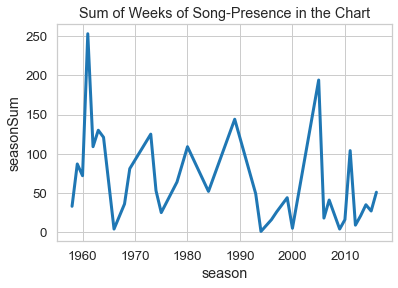

In [228]:
#Plot the sum of song-presence per season
sns.lineplot(data=sqlSongsPerSeason, x="season", y="seasonSum",palette='pastel').set(title='Sum of Weeks of Song-Presence in the Chart')



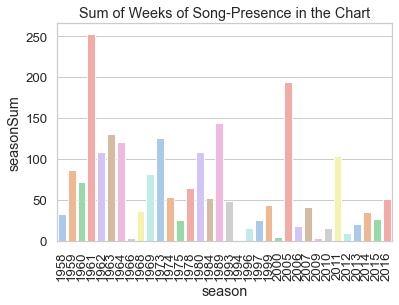

In [229]:

sns.barplot(data=sqlSongsPerSeason, x="season", y="seasonSum",palette='pastel').set(title='Sum of Weeks of Song-Presence in the Chart')
plt.xticks(rotation = 'vertical')
plt.show()


<AxesSubplot:title={'center':'Count of titles'}, ylabel='seasonCount'>

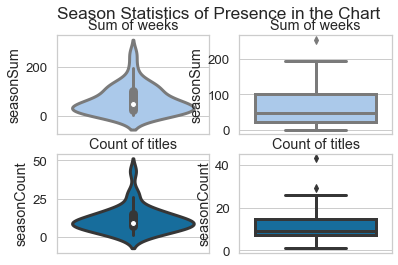

In [230]:
fig, axes = plt.subplots(2, 2)
fig.suptitle('Season Statistics of Presence in the Chart')
axes[0,0].set_title("Sum of weeks")
axes[0,1].set_title("Sum of weeks")
axes[1,0].set_title("Count of titles")
axes[1,1].set_title("Count of titles")

sns.violinplot(ax=axes[0,0],y="seasonSum",data=sqlSongsPerSeason, palette="pastel")
sns.boxplot(ax=axes[0,1], y=sqlSongsPerSeason["seasonSum"], palette="pastel" )
sns.violinplot(ax=axes[1,0],y="seasonCount",data=sqlSongsPerSeason, palette="colorblind")
sns.boxplot(ax=axes[1,1], y=sqlSongsPerSeason["seasonCount"], palette="colorblind" )



Do the same analysis for decades:

In [231]:
sqlSongsPerDecade = sqldf("""select count(*) as decadeCount, sum(weeksOnChartPerSeason) as decadeSum ,decade*10+1900 as decade
                            from dfXmasSongsRaw 
                            group by decade
                            order by decade;""")
sqlSongsPerDecade

,decadeCount,decadeSum,decade
0,21,83,21400
1,144,798,21500
2,44,312,21600
3,35,257,21700
4,24,148,21800
5,50,298,21900
6,69,263,22000


In [232]:
#Plot the result: Counts of songs per season
sns.set_style("whitegrid")


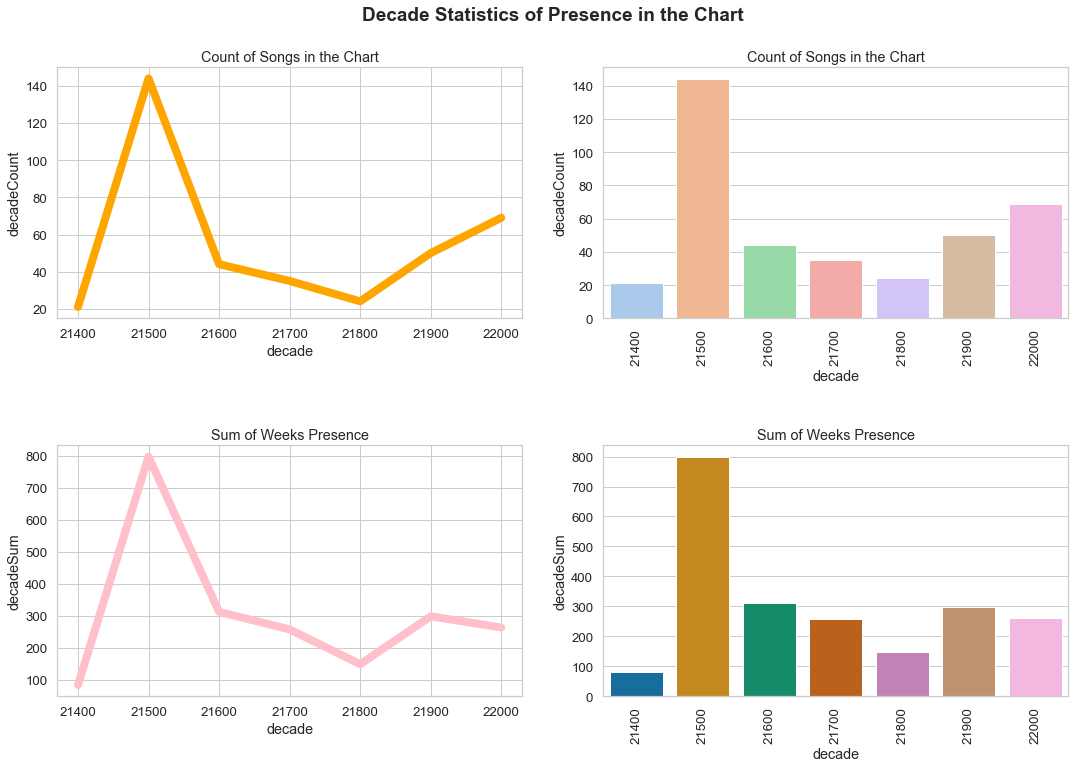

In [233]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 10, forward=True)
fig.suptitle('Decade Statistics of Presence in the Chart',fontweight='bold',fontsize=19,y=1.01)
fig.tight_layout(h_pad=7, w_pad=3)
axes[0,0].set_title("Sum of Decades")
axes[0,1].set_title("Sum of Decades")
axes[1,0].set_title("Count of titles")
axes[1,1].set_title("Count of titles")


sns.lineplot(ax=axes[0,0],linewidth=8,data=sqlSongsPerDecade, x="decade", y="decadeCount",color='orange').set(title='Count of Songs in the Chart')
sns.barplot(ax=axes[0,1],data=sqlSongsPerDecade, x="decade", y="decadeCount",palette='pastel').set(title='Count of Songs in the Chart')
sns.lineplot(ax=axes[1,0],linewidth=8,data=sqlSongsPerDecade, x="decade", y="decadeSum",color='pink').set(title='Sum of Weeks Presence')
sns.barplot(ax=axes[1,1],data=sqlSongsPerDecade, x="decade", y="decadeSum",palette='colorblind').set(title='Sum of Weeks Presence')

axes[0][1].tick_params(axis='x', rotation=90) 
axes[1][1].tick_params(axis='x', rotation=90) 


__It seems like Christmas-Songs were the most popular in the 1960ies while the least in 1990ies with an increasing trend in the last decade__ (only in terms of number of songs but not of presence in the chart!).

In [234]:
dfXmasSongsRaw[:1]

,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,...,initialStartPosition,BeforeXmas,xmasInSong,all,decade,weekPosCat,weekPosCat50,match,matchMe,weeksOnChartPerSeason
0,http://www.billboard.com/charts/hot-100/2000-0...,2000-01-01 00:00:00,53,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,NaN,49,...,53,0,False,,2000,2,0,This Gift98 Degrees1999,This Gift98 Degrees1999,3


In [235]:
dfXmasSongsRaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 386
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   url                       387 non-null    object        
 1   weekid                    387 non-null    object        
 2   week_position             387 non-null    int64         
 3   song                      387 non-null    object        
 4   performer                 387 non-null    object        
 5   performerGroup            387 non-null    int64         
 6   songid                    387 non-null    object        
 7   instance                  387 non-null    int64         
 8   previous_week_position    279 non-null    float64       
 9   peak_position             387 non-null    int64         
 10  weeks_on_chart            387 non-null    int64         
 11  year                      387 non-null    int64         
 12  month                 

### Machine Learning Model to predict the duration on chart
Run a machine learning model to investigate whether it is appropriate to predict weeks on chart per season and check which factor has how much influence. Because there are 13 different classes of week-duration (1-13) and too few datasets reclassify the duration as:
* presence of 1 week only
* presence of 1 month (2-4 weeks)
* presence of more than a month (5 weeks or more)


In [236]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#just for fun: add another variable: length of songname
dfXmasSongsRaw['songnamelength'] = dfXmasSongsRaw['song'].str.len()
dfXmasSongsRaw['xmasInSongR'] = np.where(dfXmasSongsRaw['xmasInSong'] == True,1, 0)
dfXmasSongsRaw['positionChangeWithinWeek'] = dfXmasSongsRaw['positionChangeWithinWeek'].fillna(0)

#Reclassification of duration
dfXmasSongsRaw['weeksOnChartPerSeasonR'] = np.where(dfXmasSongsRaw['weeksOnChartPerSeason']>1,1,0)
dfXmasSongsRaw['weeksOnChartPerSeasonR'] = np.where(dfXmasSongsRaw['weeksOnChartPerSeason']>4,2,dfXmasSongsRaw['weeksOnChartPerSeasonR'])
dfXmasSongsRaw['weeksOnChartPerSeasonR'].value_counts()


2    222
1    138
0     27
Name: weeksOnChartPerSeasonR, dtype: int64

In [237]:
dfXmasSongsRaw[:3]

,url,weekid,week_position,song,performer,performerGroup,songid,instance,previous_week_position,peak_position,...,all,decade,weekPosCat,weekPosCat50,match,matchMe,weeksOnChartPerSeason,songnamelength,xmasInSongR,weeksOnChartPerSeasonR
0,http://www.billboard.com/charts/hot-100/2000-0...,2000-01-01 00:00:00,53,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,NaN,49,...,,2000,2,0,This Gift98 Degrees1999,This Gift98 Degrees1999,3,9,0,1
1,http://www.billboard.com/charts/hot-100/2000-0...,2000-08-01 00:00:00,49,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,53.0,49,...,,2000,2,0,This Gift98 Degrees1999,This Gift98 Degrees1999,3,9,0,1
2,http://www.billboard.com/charts/hot-100/2000-0...,1/15/2000,79,THIS GIFT,98 Degrees,1,This Gift98 Degrees,1,49.0,49,...,,2000,4,1,This Gift98 Degrees1999,This Gift98 Degrees1999,3,9,0,1


In [238]:
#subsetting the data: keeping only relevant variables to define the ml model; 
#drop variables that hold information overall / over time-period like instance, weeks_on_chart and peak_position because they
#will not be known at time when a new song will enter the chart
x = dfXmasSongsRaw.drop(['all','url','weekid','song','performer','songid','instance','peak_position','weeks_on_chart','xmasInSong','date','xmasDate','decade','previous_week_position','weekPosCat','weekPosCat50','match','matchMe','weeksOnChartPerSeason','weeksOnChartPerSeasonR'], axis=1)
y = dfXmasSongsRaw['weeksOnChartPerSeasonR']


In [239]:
y.unique()

array([1, 0, 2])

In [240]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 386
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   week_position             387 non-null    int64  
 1   performerGroup            387 non-null    int64  
 2   year                      387 non-null    int64  
 3   month                     387 non-null    int64  
 4   day                       387 non-null    int64  
 5   season                    387 non-null    int64  
 6   positionChangeWithinWeek  387 non-null    float64
 7   numberOfDaysToXmas        387 non-null    int64  
 8   initialStartPosition      387 non-null    int64  
 9   BeforeXmas                387 non-null    int64  
 10  songnamelength            387 non-null    int64  
 11  xmasInSongR               387 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 47.4 KB


In [241]:
#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=76)
#Initial Random Forest Model
forest = RandomForestClassifier(n_estimators=500, random_state=76)
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=76)

In [242]:
#Evaluate Model Fit
forestPredictions = forest.predict(x_test)
print(confusion_matrix(y_test, forestPredictions))
print(classification_report(y_test, forestPredictions))

[[ 5  7  2]
 [ 0 38 10]
 [ 0  8 58]]
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        14
           1       0.72      0.79      0.75        48
           2       0.83      0.88      0.85        66

    accuracy                           0.79       128
   macro avg       0.85      0.68      0.71       128
weighted avg       0.81      0.79      0.78       128



__Interpretation:__    
* The model is 81% accurate (weighted avg)
* There is 100% accuracy for songs that are only 1 week present in the charts; for 2-4 weeks 72% and for more 83%
* 5 songs were correctly predicted as 1-week-presence-songs, 7 were erroneously classified as 2-4-week-presence-songs and 2 erroneously as more-than-a-month-songs
* 38 songs were correctly predicted as 2-4-week-presence-songs, 0 were erroneously classified as 1-week-presence-songs and 10 erroneously as more-than-a-month-songs
* 58 songs were correctly predicted as more-than-a-month-songs, 0 were erroneously classified as 1-week-presence-songs and 8 erroneously as 2-4-week-presence-songs


#### Hyperparameter Tuning

In [243]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators_array = [1, 4, 5, 7, 8, 9, 10, 20, 50, 75, 100, 250, 500]
results = []
bestn = -1
bestEstimator = -1
for n in n_estimators_array:
    forest = RandomForestClassifier(n_estimators=n, random_state=76)
    forest.fit(x_train, y_train)
    result = accuracy_score(y_test, forest.predict(x_test))
    results.append(result)
    if result > bestEstimator:
        bestEstimator = result
        bestn = n
    print(n, ':', result)

print("\nbest result at n={} with estimator={}".format(bestn,bestEstimator))

1 : 0.703125
4 : 0.734375
5 : 0.7734375
7 : 0.7890625
8 : 0.8046875
9 : 0.796875
10 : 0.78125
20 : 0.78125
50 : 0.796875
75 : 0.8046875
100 : 0.8046875
250 : 0.8046875
500 : 0.7890625

best result at n=8 with estimator=0.8046875


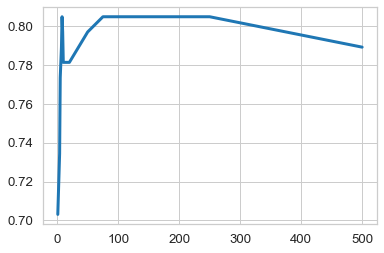

In [244]:
plt.plot(n_estimators_array, results)


Tuning the Remaining Tree

In [245]:
# Number of features to consider at every split
max_features = ['auto', None, 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, None]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier(n_estimators=bestn)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 90, cv = 3, random_state=42)
rf_random.fit(x_train, y_train)
minSamplesLeaf = rf_random.best_params_['min_samples_leaf']
maxFeatures = rf_random.best_params_['max_features']
maxDepth = rf_random.best_params_['max_depth']
rf_random.best_params_



{'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}

In [246]:
forest = RandomForestClassifier(n_estimators=bestn, min_samples_leaf=minSamplesLeaf, max_features=maxFeatures, max_depth=maxDepth)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=40, max_features='log2', n_estimators=8)

In [247]:
forestPredictions = forest.predict(x_test)
print(confusion_matrix(y_test, forestPredictions))
print(classification_report(y_test, forestPredictions))


[[ 7  5  2]
 [ 0 40  8]
 [ 0  8 58]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       0.75      0.83      0.79        48
           2       0.85      0.88      0.87        66

    accuracy                           0.82       128
   macro avg       0.87      0.74      0.77       128
weighted avg       0.83      0.82      0.82       128



_Although many different parameter changes were tried, the model could not be improved._

Finally look at __feature importance__:

In [248]:
feature_importances = pd.Series(forest.feature_importances_, index=x.columns)
feature_importances.sort_values(inplace=True, ascending=False)
print(feature_importances[:][:])

week_position               0.163301
season                      0.141718
numberOfDaysToXmas          0.134603
year                        0.129687
songnamelength              0.129431
initialStartPosition        0.086403
day                         0.067758
xmasInSongR                 0.049141
performerGroup              0.032393
positionChangeWithinWeek    0.029333
month                       0.023312
BeforeXmas                  0.012919
dtype: float64


_Interpretation_:
* season seems to be the most influential variable with nearly 20%
* week position, year and number of Days to Christmas are also influential with each more than 10%
* the remaining 8 variables are between nearly 2% and 9%
* whether the song first appeared before or after Christmas seems to have the least impact

<AxesSubplot:>

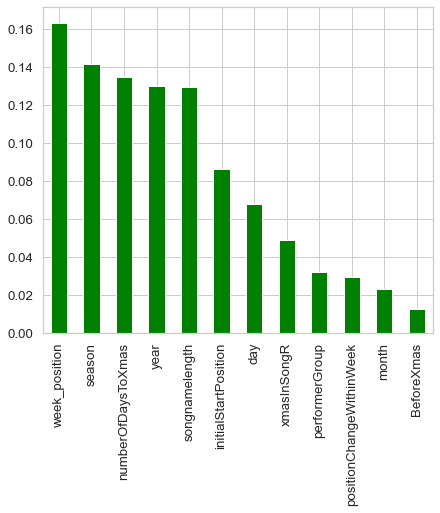

In [249]:
feature_importances.plot(kind='bar', figsize=(7,6),color='g')


Finally export the dataset and its additionally computed variables into a separate csv file (for further analysis externally)

In [252]:
dfXmasSongsRaw.drop(['match','matchMe'], axis=1,inplace=True)

expDataFl = os.path.join(path,'christmas_billboard_data_export.csv')
dfXmasSongsRaw.to_csv(expDataFl)
